IA & Data science (LU3IN0226) -- 2023-2024
--------
*&copy; Equipe pédagogique: Téo Guichoux, Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*


# TD-TME08: arbres de décision numériques, apprentissage non-supervisé

L'objectif de ce TP est d'implémenter des algorithmes d'apprentissage non-supervisé, en particulier, l'algorithme de clutering hiérarchique ascendant.

<font color="RED" size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Tiphaine GAYET

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-08</tt> et rajouter à la suite de <tt>tme-08</tt> les noms des membres du binômes séparés par un tiret.

<font color="RED" size="+1">IMPORTANT: soumission de votre fichier final</font>

**Nom à donner au fichier à poster** : *tme-08-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**


## Préparation

L'archive récupérée avec ce fichier contient aussi le répertoire <code>data</code> qui contient les bases pour expérimenter vos fonctions.

In [12]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# un nouvel import utile pour la 3D:
from matplotlib import cm

# Les instructions suivantes sont TRES utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# Pour mesurer le temps
import time

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'iads'

In [ ]:
# Importation de la librairie seaborn:
import seaborn as sns


## Arbres de décision numériques

Pour tester la construction d'arbres de décision numériques, on utilise la base de Iris de Fischer (4 variables de description numériques, et 3 valeurs de classes à reconnaître).

In [8]:
# Le dataset des iris est fourni dans le package seaborn, on l'obtient ainsi:
iris_df = sns.load_dataset('iris')

# Contenu du dataframe :
iris_df

# Remarque: dans ce dataframe, la colonne "species" est la colonne de la classe. 
# C'est la seule colonne qui ne contient pas de valeurs réelles.

NameError: name 'sns' is not defined

In [ ]:
# Avec Seaborn, on peut construire le corrélogramme de ce dataset:
sns.pairplot(iris_df,hue='species',palette='bright')


<font color="RED" size="+1"><b>[Q]</b></font> Examiner ce corrélogramme et expliquer ce qu'il représente:
- pourquoi certains affichages représentent des points et d'autres des courbes ?

De plus, en examinant ce corrélogramme : 
- est-ce que le problème de classification des iris semble être un problème difficile ? Expliquez ?
- à votre avis, sans faire de calculs, quels sont les 2 attributs qui semblent le plus discrimant pour reconnaître la valeur de la classe ?

<i>Rajouter ci-dessous une boîte "markdown" pour donner vos réponses.</i>

- si les axes représentent des variables différentes, des points sont affichés. Cependant, lorsque les mêmes variables sont comparées, Seaborn utilise des courbes pour représenter la densité de points.

- la classification des iris n'a pas l'air très difficile, on observe des classes bien distinctes. Si les caractéristiques des setosa de démarquent tres bien, c'est un peu plus compliqué pour les versicolor et virginica.

- les attributs les plus discriminants sont petal_width et petal_length, les clusters semblent mieux séparé

In [7]:
# Passer du dataframe à des arrays:
iris_desc = np.array(iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
iris_label = np.array(iris_df['species']) # species est la colonne contenant le label/la classe.

# obtenir les noms des colonnes :
iris_noms = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

print("Noms des features: ",iris_noms)
print("Noms des labels: ",np.unique(iris_label))

NameError: name 'iris_df' is not defined

In [5]:
# Exemple : fleurs dont la 'sepal_length' vaut 6.3
iris_label[iris_desc[:,0] == 6.3]

NameError: name 'iris_label' is not defined

<font color="RED" size="+1"><b>[Q]</b></font> Vérifier que la fonction <code>classe_majoritaire</code> et la fonction d'<code>entropie</code> écrites lors du TME précédent sont bien installées dans votre librairie.



In [1]:
# Vérification sur nos données:
liste_classes = iris_label[iris_desc[:,0] == 6.3]
classe_majo = classif.classe_majoritaire(liste_classes)

print("Les classes: ", liste_classes)
print("Classe majoritaire: ", classe_majo)
print(f'Entropie: {classif.entropie(liste_classes):0.3f}')

NameError: name 'iris_label' is not defined

### Discrétisation des attributs numériques

<div class="alert alert-block alert-success">
    
Comme cela a été dit en cours, **discrétiser** un attribut numérique consiste en trouver un seuil de coupure dans son ensemble de valeurs après les avoir ordonnées.
</div>    


Ci-dessous, la méthode <code>discretise</code> qui permet de trouver le seuil de coupure optimal dans un ensemble de valeurs associées à des classes (labels).


In [10]:
def discretise(m_desc, m_class, num_col):
    """ input:
            - m_desc : (np.array) matrice des descriptions toutes numériques
            - m_class : (np.array) matrice des classes (correspondant à m_desc)
            - num_col : (int) numéro de colonne de m_desc à considérer
            - nb_classes : (int) nombre initial de labels dans le dataset (défaut: 2)
        output: tuple : ((seuil_trouve, entropie), (liste_coupures,liste_entropies))
            -> seuil_trouve (float): meilleur seuil trouvé
            -> entropie (float): entropie du seuil trouvé (celle qui minimise)
            -> liste_coupures (List[float]): la liste des valeurs seuils qui ont été regardées
            -> liste_entropies (List[float]): la liste des entropies correspondantes aux seuils regardés
            (les 2 listes correspondent et sont donc de même taille)
            REMARQUE: dans le cas où il y a moins de 2 valeurs d'attribut dans m_desc, aucune discrétisation
            n'est possible, on rend donc ((None , +Inf), ([],[])) dans ce cas            
    """
    # Liste triée des valeurs différentes présentes dans m_desc:
    l_valeurs = np.unique(m_desc[:,num_col])
    
    # Si on a moins de 2 valeurs, pas la peine de discrétiser:
    if (len(l_valeurs) < 2):
        return ((None, float('Inf')), ([],[]))
    
    # Initialisation
    best_seuil = None
    best_entropie = float('Inf')
    
    # pour voir ce qui se passe, on va sauver les entropies trouvées et les points de coupures:
    liste_entropies = []
    liste_coupures = []
    
    nb_exemples = len(m_class)
    
    for v in l_valeurs:
        cl_inf = m_class[m_desc[:,num_col]<=v]
        cl_sup = m_class[m_desc[:,num_col]>v]
        nb_inf = len(cl_inf)
        nb_sup = len(cl_sup)
        
        # calcul de l'entropie de la coupure
        val_entropie_inf = classif.entropie(cl_inf) # entropie de l'ensemble des inf
        val_entropie_sup = classif.entropie(cl_sup) # entropie de l'ensemble des sup
        
        val_entropie = (nb_inf / float(nb_exemples)) * val_entropie_inf \
                       + (nb_sup / float(nb_exemples)) * val_entropie_sup
        
        # Ajout de la valeur trouvée pour retourner l'ensemble des entropies trouvées:
        liste_coupures.append(v)
        liste_entropies.append(val_entropie)
        
        # si cette coupure minimise l'entropie, on mémorise ce seuil et son entropie:
        if (best_entropie > val_entropie):
            best_entropie = val_entropie
            best_seuil = v
    
    return (best_seuil, best_entropie), (liste_coupures,liste_entropies)

Pour  sepal_length
Seuil de coupure trouvé: 5.500 et son entropie: 0.64843


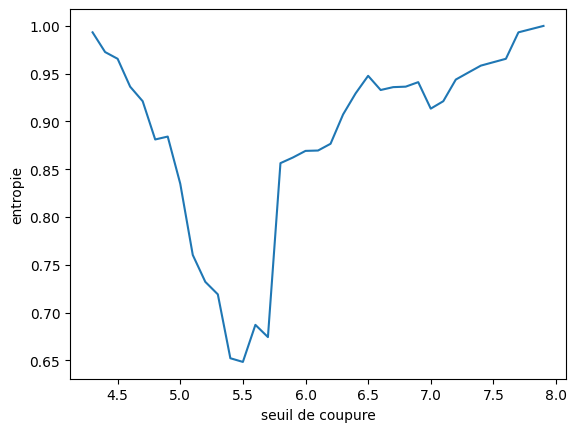

In [11]:
# Exemple d'utilisation:
numero_colonne = 0
resultat, liste_vals = discretise(iris_desc,iris_label,numero_colonne)

print("Pour ", iris_noms[numero_colonne])
print(f"Seuil de coupure trouvé: {resultat[0]:1.3f} et son entropie: {resultat[1]:1.5f}" )

# affichage de la variation de l'entropie en fonction du choix du seuil:
X,Y = liste_vals
plt.plot(X,Y)
plt.ylabel('entropie')
plt.xlabel('seuil de coupure')
plt.show()

Pour  petal_length
Seuil de coupure trouvé: 1.700 et son entropie: 0.48036


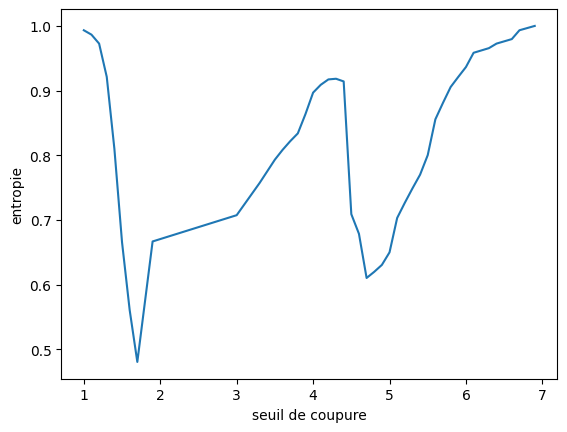

In [12]:
# Autre exemple:
numero_colonne = 2

resultat, liste_vals = discretise(iris_desc,iris_label,numero_colonne)

print("Pour ", iris_noms[numero_colonne])
print(f"Seuil de coupure trouvé: {resultat[0]:1.3f} et son entropie: {resultat[1]:1.5f}" )

# affichage de la variation de l'entropie en fonction du choix du seuil:
X,Y = liste_vals
plt.plot(X,Y)
plt.ylabel('entropie')
plt.xlabel('seuil de coupure')
plt.show()

<div class="alert alert-block alert-warning">
Une fois un seuil de coupure $s$ trouvé sur un attribut $n$, on partitionne la base d'apprentissage en 2 ensembles:
- l'ensemble des exemples qui ont une valeur inférieure ou égale à $s$ pour l'attribut $n$
- l'ensemble des exemples qui ont une valeur strictement supérieure à $s$ pour l'attribut $n$
</div>    


La fonction <code>partionne</code> ci-dessous prend en argument deux numpy array $m_{desc}$ et $m_{class}$ qui représentent une base d'apprentissage, un numéro de colonne $n$ et une valeur de seuil $s$ et rend un tuple composé  de 2 tuples de numpy arrays:
- le premier tuple est composé de l'ensemble des descriptions de tous les exemples de $T$ qui ont une valeur pour la colonne $n$ inférieure ou égale à $s$ et l'ensemble de leur classe;
- le second tuple est composé de l'ensemble des descriptions de tous les exemples de $T$ qui ont une valeur pour la colonne $n$ strictement supérieure à $s$ et l'ensemble de leur classe;


In [13]:
def partitionne(m_desc,m_class,n,s):
    """ input:
            - m_desc : (np.array) matrice des descriptions toutes numériques
            - m_class : (np.array) matrice des classes (correspondant à m_desc)
            - n : (int) numéro de colonne de m_desc
            - s : (float) seuil pour le critère d'arrêt
        Hypothèse: m_desc peut être partitionné ! (il contient au moins 2 valeurs différentes)
        output: un tuple composé de 2 tuples
    """
    return ((m_desc[m_desc[:,n]<=s], m_class[m_desc[:,n]<=s]), \
            (m_desc[m_desc[:,n]>s], m_class[m_desc[:,n]>s]))

In [14]:
# Exemple d'utilisation :

# Recherche point de coupure :
numero_colonne = 3
resultat, liste_vals = discretise(iris_desc,iris_label,numero_colonne)
print(f"Seuil de coupure trouvé: {resultat[0]:1.3f} et son entropie: {resultat[1]:1.5f}" )

# partitionnement :
((left_data,left_class), (right_data,right_class)) = partitionne(iris_desc,iris_label, numero_colonne,resultat[0])

print("Nombre d'exemples à gauche : ", len(left_class), " Nombre d'exemples à droite : ", len(right_class) )

Seuil de coupure trouvé: 0.500 et son entropie: 0.45466
Nombre d'exemples à gauche :  49  Nombre d'exemples à droite :  101


### Implémentation des arbres numériques

Afin de représenter des arbres de décision numériques, on créé une nouvelle classe qui permet de définir des noeuds internes de l'arbre associés à des attributs numériques.

<b>Remarque:</b> on se place ici dans le cas où l'arbre de décision final ne contiendra que des noeuds numériques. Il n'y a donc pas à prévoir de noeud catégoriel dans cet arbre (la version générale sera abordée un peu plus loin dans ce notebook).

<font color="RED" size="+1"><b>[Q]</b></font> Compléter la classe suivante pour pouvoir classifier avec un noeud numérique.

In [15]:
import graphviz as gv

class NoeudNumerique:
    """ Classe pour représenter des noeuds numériques d'un arbre de décision
    """
    def __init__(self, num_att=-1, nom=''):
        """ Constructeur: il prend en argument
            - num_att (int) : le numéro de l'attribut auquel il se rapporte: de 0 à ...
              si le noeud se rapporte à la classe, le numéro est -1, on n'a pas besoin
              de le préciser
            - nom (str) : une chaîne de caractères donnant le nom de l'attribut si
              il est connu (sinon, on ne met rien et le nom sera donné de façon 
              générique: "att_Numéro")
        """
        self.attribut = num_att    # numéro de l'attribut
        if (nom == ''):            # son nom si connu
            self.nom_attribut = 'att_'+str(num_att)
        else:
            self.nom_attribut = nom 
        self.seuil = None          # seuil de coupure pour ce noeud
        self.Les_fils = None       # aucun fils à la création, ils seront ajoutés
        self.classe   = None       # valeur de la classe si c'est une feuille
        
    def est_feuille(self):
        """ rend True si l'arbre est une feuille 
            c'est une feuille s'il n'a aucun fils
        """
        return self.Les_fils == None
    
    def ajoute_fils(self, val_seuil, fils_inf, fils_sup):
        """ val_seuil : valeur du seuil de coupure
            fils_inf : fils à atteindre pour les valeurs inférieures ou égales à seuil
            fils_sup : fils à atteindre pour les valeurs supérieures à seuil
        """
        if self.Les_fils == None:
            self.Les_fils = dict()            
        self.seuil = val_seuil
        self.Les_fils['inf'] = fils_inf
        self.Les_fils['sup'] = fils_sup        
    
    def ajoute_feuille(self,classe):
        """ classe: valeur de la classe
            Ce noeud devient un noeud feuille
        """
        self.classe    = classe
        self.Les_fils  = None   # normalement, pas obligatoire ici, c'est pour être sûr
        
    def classifie(self, exemple):
        """ exemple : numpy.array
            rend la classe de l'exemple (pour nous, soit +1, soit -1 en général)
            on rend la valeur 0 si l'exemple ne peut pas être classé (cf. les questions
            posées en fin de ce notebook)
        """
        #############
        # COMPLETER CETTE PARTIE 
        #
        #############
        raise NotImplementedError("A implémenter plus tard (voir plus loin)")

    
    def compte_feuilles(self):
        """ rend le nombre de feuilles sous ce noeud
        """
        #############
        # COMPLETER CETTE PARTIE AUSSI
        #
        #############
        raise NotImplementedError("A implémenter plus tard (voir plus loin)")
     
    def to_graph(self, g, prefixe='A'):
        """ construit une représentation de l'arbre pour pouvoir l'afficher graphiquement
            Cette fonction ne nous intéressera pas plus que ça, elle ne sera donc 
            pas expliquée            
        """
        if self.est_feuille():
            g.node(prefixe,str(self.classe),shape='box')
        else:
            g.node(prefixe, str(self.nom_attribut))
            self.Les_fils['inf'].to_graph(g,prefixe+"g")
            self.Les_fils['sup'].to_graph(g,prefixe+"d")
            g.edge(prefixe,prefixe+"g", '<='+ str(self.seuil))
            g.edge(prefixe,prefixe+"d", '>'+ str(self.seuil))                
        return g


Cet arbre contient  2  feuilles.


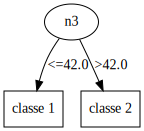

In [17]:
# Exemple d'utilisation: 
un_arbre= NoeudNumerique(nom='n1')
un_arbre.ajoute_feuille("classe 1")
un_arbre.est_feuille()
un_arbre1 = NoeudNumerique(nom="n2")
un_arbre1.ajoute_feuille("classe 2")
un_arbre2 = NoeudNumerique(nom="n3")
un_arbre2.ajoute_fils(42.0,un_arbre,un_arbre1)
print("Cet arbre contient ", un_arbre2.compte_feuilles()," feuilles.")

gtree = gv.Digraph(format='png')
un_arbre2.to_graph(gtree)



<font color="RED" size="+1"><b>[Q]</b></font> En utilisant la fonction `discretise`, compléter la fonction `construit_AD_num` (ça ressemble à la version catégorielle réalisée lors de la séance précédente) afin de pouvoir construire des arbres de décision avec des valeurs numériques.
Les attributs numériques seront discrétisés en 2 valeurs catégorielles.

In [18]:
def construit_AD_num(X,Y,epsilon,LNoms = []):
    """ X,Y : dataset
        epsilon : seuil d'entropie pour le critère d'arrêt 
        LNoms : liste des noms de features (colonnes) de description 
    """
    
    # dimensions de X:
    (nb_lig, nb_col) = X.shape
    
    entropie_classe = classif.entropie(Y)
    
    if (entropie_classe <= epsilon) or  (nb_lig <=1):
        # ARRET : on crée une feuille
        noeud = NoeudNumerique(-1,"Label")
        noeud.ajoute_feuille(classif.classe_majoritaire(Y))
    else:
        gain_max = 0.0  # meilleur gain trouvé (initalisé à 0.0 => aucun gain)
        i_best = -1     # numéro du meilleur attribut (init à -1 (aucun))
        
        #############
        
        # COMPLETER CETTE PARTIE : ELLE DOIT PERMETTRE D'OBTENIR DANS
        # i_best : le numéro de l'attribut qui maximise le gain d'information.  En cas d'égalité,
        #          le premier rencontré est choisi.
        # gain_max : la plus grande valeur de gain d'information trouvée.
        # Xbest_tuple : le tuple rendu par partionne() pour le meilleur attribut trouvé
        # Xbest_seuil : le seuil de partitionnement associé au meilleur attribut
        #
        # Remarque : attention, la fonction discretise() peut renvoyer un tuple contenant
        # None (pas de partitionnement possible)n dans ce cas, on considèrera que le
        # résultat d'un partitionnement est alors ((X,Y),(None,None))
        
        
        ############
        if (i_best != -1): # Un attribut qui amène un gain d'information >0 a été trouvé
            if len(LNoms)>0:  # si on a des noms de features
                noeud = NoeudNumerique(i_best,LNoms[i_best]) 
            else:
                noeud = NoeudNumerique(i_best)
            ((left_data,left_class), (right_data,right_class)) = Xbest_tuple
            noeud.ajoute_fils( Xbest_seuil, \
                              construit_AD_num(left_data,left_class, epsilon, LNoms), \
                              construit_AD_num(right_data,right_class, epsilon, LNoms) )
        else: # aucun attribut n'a pu améliorer le gain d'information
              # ARRET : on crée une feuille
            noeud = NoeudNumerique(-1,"Label")
            noeud.ajoute_feuille(classif.classe_majoritaire(Y))
        
    return noeud

In [19]:
class ClassifierArbreNumerique(classif.Classifier):
    """ Classe pour représenter un classifieur par arbre de décision numérique
    """
    
    def __init__(self, input_dimension, epsilon, LNoms=[]):
        """ Constructeur
            Argument:
                - intput_dimension (int) : dimension de la description des exemples
                - epsilon (float) : paramètre de l'algorithme (cf. explications précédentes)
                - LNoms : Liste des noms de dimensions (si connues)
            Hypothèse : input_dimension > 0
        """
        self.dimension = input_dimension
        self.epsilon = epsilon
        self.LNoms = LNoms
        # l'arbre est manipulé par sa racine qui sera un Noeud
        self.racine = None
        
    def toString(self):
        """  -> str
            rend le nom du classifieur avec ses paramètres
        """
        return 'ClassifierArbreDecision ['+str(self.dimension) + '] eps='+str(self.epsilon)
        
    def train(self, desc_set, label_set):
        """ Permet d'entrainer le modele sur l'ensemble donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """        
        self.racine = construit_AD_num(desc_set,label_set,self.epsilon,self.LNoms)
    
    def score(self,x):
        """ rend le score de prédiction sur x (valeur réelle)
            x: une description
        """
        # cette méthode ne fait rien dans notre implémentation :
        pass
    
    def predict(self, x):
        """ x (array): une description d'exemple
            rend la prediction sur x             
        """
        return self.racine.classifie(x)

    def accuracy(self, desc_set, label_set):  # Version propre à aux arbres
        """ Permet de calculer la qualité du système sur un dataset donné
            desc_set: ndarray avec des descriptions
            label_set: ndarray avec les labels correspondants
            Hypothèse: desc_set et label_set ont le même nombre de lignes
        """
        nb_ok=0
        for i in range(desc_set.shape[0]):
            if self.predict(desc_set[i,:]) == label_set[i]:
                nb_ok=nb_ok+1
        acc=nb_ok/(desc_set.shape[0] * 1.0)
        return acc

    def number_leaves(self):
        """ rend le nombre de feuilles de l'arbre
        """
        return self.racine.compte_feuilles()
    
    def affiche(self,GTree):
        """ affichage de l'arbre sous forme graphique
            Cette fonction modifie GTree par effet de bord
        """
        self.racine.to_graph(GTree)
# ---------------------------


Cet arbre possède  11  feuilles.


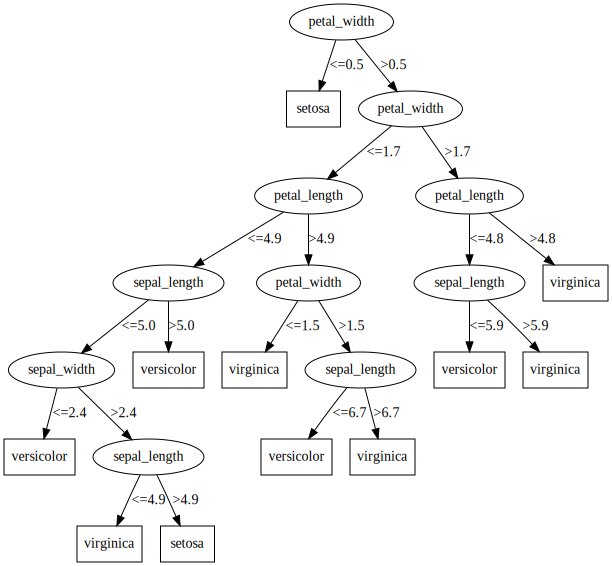

In [20]:
# Initialiation d'un arbre pour le dataset Iris:
arbre_iris = ClassifierArbreNumerique(len(iris_noms), 0.0, iris_noms)

# Construction de l'arbre de décision à partir du dataset Iris
arbre_iris.train(iris_desc,iris_label)

# Construction de la représentation graphique (affichage)
graphe_arbre_iris = gv.Digraph(format='png')
arbre_iris.affiche(graphe_arbre_iris)

# Affichage du graphe obtenu:
print("Cet arbre possède ",arbre_iris.number_leaves()," feuilles.")
graphe_arbre_iris

In [21]:
# mesure du taux de bonne classification
arbre_iris.accuracy(iris_desc,iris_label)

1.0

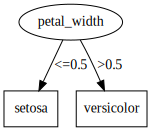

In [22]:
# Nouvel essai avec un seuil d'entropie élevé:
# Initialiation d'un arbre pour le dataset Elections:
arbre_iris2 = ClassifierArbreNumerique(len(iris_noms),0.75, iris_noms)

# Construction de l'arbre de décision à partir du dataset Elections
arbre_iris2.train(iris_desc,iris_label)

# Construction de la représentation graphique (affichage)
graphe_arbre_iris2 = gv.Digraph(format='png')
arbre_iris2.affiche(graphe_arbre_iris2)

# Affichage du graphe obtenu:
graphe_arbre_iris2

In [23]:
# mesure du taux de bonne classification
arbre_iris2.accuracy(iris_desc,iris_label)

0.66

### Expérimentations

<font color="RED" size="+1"><b>[Q]</b></font> Tester cet algorithme en effectuant une validation croisée sur les données des iris (en prenant $0.0$ comme seuil d'entropie).

In [24]:
print("Remarque: j'ai mis des affichage dans la fonction validation croisée afin de montrer ce qui se passe.\n")

# ################### A COMPLETER 


# ################### 
       
print("\nValidation croisée sur les iris avec comme seuil ",0.0)
print("Perf obtenues : ",res_all)
print(f'\nAccuracy moyenne: {res_moy:.3f}\técart type: {res_sd:.3f}')

Remarque: j'ai mis des affichage dans la fonction validation croisée afin de montrer ce qui se passe.

------ affichage validation croisée (optionnel)
Itération 0: taille base app.= 135	taille base test= 15	Taux de bonne classif: 1.0000
Itération 1: taille base app.= 135	taille base test= 15	Taux de bonne classif: 0.9333
Itération 2: taille base app.= 135	taille base test= 15	Taux de bonne classif: 1.0000
Itération 3: taille base app.= 135	taille base test= 15	Taux de bonne classif: 0.9333
Itération 4: taille base app.= 135	taille base test= 15	Taux de bonne classif: 0.8667
Itération 5: taille base app.= 135	taille base test= 15	Taux de bonne classif: 0.8667
Itération 6: taille base app.= 135	taille base test= 15	Taux de bonne classif: 0.9333
Itération 7: taille base app.= 135	taille base test= 15	Taux de bonne classif: 1.0000
Itération 8: taille base app.= 135	taille base test= 15	Taux de bonne classif: 0.9333
Itération 9: taille base app.= 135	taille base test= 15	Taux de bonne class

<font color="RED" size="+1"><b>[Q]</b></font> Etudier la variation du taux de bonne classification lorsque l'on fait varier le seuil d'entropie utilisé pour l'apprentissage. Tracer ensuite la courbe de l'accuracy moyenne (incluant son écart type) quand le seuil d'entropie varie.

run  0: seuil d'entropie = 0.000           accuracy moyenne: 0.947           écart type: 0.050
run  1: seuil d'entropie = 0.101           accuracy moyenne: 0.947           écart type: 0.050
run  2: seuil d'entropie = 0.202           accuracy moyenne: 0.947           écart type: 0.050
run  3: seuil d'entropie = 0.303           accuracy moyenne: 0.947           écart type: 0.050
run  4: seuil d'entropie = 0.404           accuracy moyenne: 0.940           écart type: 0.055
run  5: seuil d'entropie = 0.505           accuracy moyenne: 0.940           écart type: 0.055
run  6: seuil d'entropie = 0.606           accuracy moyenne: 0.940           écart type: 0.055
run  7: seuil d'entropie = 0.707           accuracy moyenne: 0.653           écart type: 0.027
run  8: seuil d'entropie = 0.808           accuracy moyenne: 0.653           écart type: 0.027
run  9: seuil d'entropie = 0.909           accuracy moyenne: 0.653           écart type: 0.027
run 10: seuil d'entropie = 1.010           accurac

Pour pouvoir afficher la courbe des variations de l'accuracy en affichant aussi l'écart type correspondant à chaque valeur, on utilise la fonction `lineplot` de seaborn, pour cela, il est nécessaire dans un premier temps de mettre les résultats obtenus dans un dataframe :
- avec 2 colonnes: 'Entropie' et 'Accuracy'
- chaque ligne donne le résultat d'un taux de bonne classification obtenu dans la validation croisée pour une valeur de seuil d'entropie : il y a donc 10 lignes par seuil d'entropie, chaque ligne avec le résultat d'une étape de la validation croisée.

<font color="RED" size="+1"><b>[Q]</b></font> Construire le dataframe ainsi défini.

In [26]:
df_res = pd.DataFrame(columns=['Entropie', 'Accuracy'])

# ################### A COMPLETER 


# ################### 
# Le datataframe obtenu :
df_res

,Entropie,Accuracy
0,0.00,1.000000
1,0.00,0.933333
2,0.00,1.000000
3,0.00,0.933333
4,0.00,0.866667
...,...,...
105,1.01,0.333333
106,1.01,0.333333
107,1.01,0.333333
108,1.01,0.333333


L'affichage se fait avec la fonction `lineplot` de seaborn. 

**Remarque**: le calcul de la moyenne et de l'écart type pour une même valeur de seuil est géré par la fonction.

<Axes: xlabel='Entropie', ylabel='Accuracy'>

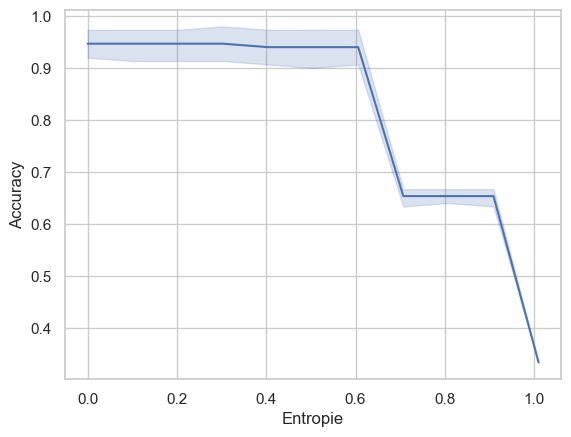

In [27]:
# Tracé avec lineplot
sns.set_theme(style="whitegrid")
sns.lineplot(x="Entropie", y="Accuracy", data=df_res)

<font color="RED" size="+1"><b>[Q]</b></font> Comparer les résultats obtenus avec la validation croisée avec les résultats obtenus avec les autres classifieurs (numériques) que vous avez implémentés.

<b>Remarque:</b> pour pouvoir utiliser les algorithmes précédents (knn, perceptron,...) vous devez utiliser leur version multi-classes.

### Pour aller plus loin... (optionnel)

La version générale d'un classifieur par arbre de décision doit pouvoir gérer des datasets contenant à la fois des variables numériques mais aussi catégorielles. En "fusionnant" les 2 classes `ClassifierArbreDecision` et `ClassifierArbreNumerique`, définissez une classe `ClassifierArbre` qui implémente cette version générale.

## Apprentissage non supervisé : la classification hiérarchique ascendante

Dans cette partie, le travail à réaliser décompose en 2 phases :
- dans la phase 1, le travail porte sur la base d'apprentissage <code>base-2D.csv</code> qui contient des exemples décrits dans $R^2$. Ainsi, il est plus aisé de visualiser les résultats des fonctions à écrire ;
- dans la phase 2, les fonctions écrites dans la phase précédente sont à utiliser avec la base d'apprentissage `base-Paris.csv`.

**Attention**: vos fonctions doivent **dès leur création** pouvoir s'appliquer **quelle que soit la dimension** des exemples traités.

**Remarque**: pour écrire les fonctions demandées, il est important d'éviter d'utiliser des boucles autant que possible.

### Phase 1: implémentation des fonctions et travail sur base_2D.csv

#### Chargement du fichier "base_2D.csv"

Charger le fichier `base_2D.csv` et, par exemple avec la fonction `read_csv` de pandas. Le résultat est stocké sous la forme d'un dataframe.

In [28]:
# data_2D =   # A COMPLETER


print("Il y a", len(data_2D), "exemples dans la base.")

Il y a 14 exemples dans la base.


In [29]:
# Le dataframe correspondant:
data_2D

,X1,X2
0,0.0,4.0
1,1.0,3.5
2,1.0,1.0
3,2.0,1.0
4,2.0,2.0
5,4.0,4.0
6,4.0,5.0
7,4.0,6.0
8,4.5,1.0
9,4.5,6.0


<font size="+1" color="RED">**[Q]**</font> Afficher la base sous forme graphique.


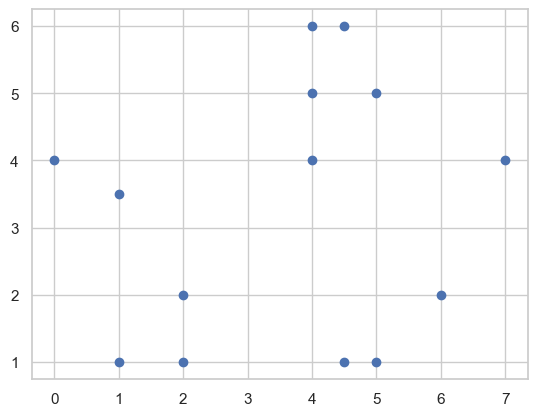

#### Normalisation des données

<font size="+1" color="RED"><b>[Q]</b></font> Donner les instructions permettant d'afficher les valeurs minimales et maximales de chaque colonne du dataframe `base_2D`.

Remarque : soyez général ! Il faut que ces instructions restent valables quel que soit le dataframe donné (noms et nombre de colonnes non connus au départ par exemple).


Minimum et maximum de chaque colonne:
colonne X1 : 0.0 7.0
colonne X2 : 1.0 6.0


<font size="+1" color="RED"><b>[Q]</b></font> En utilisant le minimum et le maximum de chaque variable, et en se référant à la méthode de normalisation présentée au cours 8, écrire la fonction <code>normalisation</code> qui prend en argument un <code>DataFrame</code> et rend le dataframe obtenu en normalisant chaque colonne de ce <code>DataFrame</code> (ie. les valeurs de la matrice résultat doivent être dans l'intervalle $[0,1])$.


<font size="+1" color="RED"><b>[Q]</b></font> Normaliser les données de la base-2D et afficher leur représentation graphique: vérifier que le tracé est le même que celui obtenu avant la normalisation (aux valeurs des axes près).

In [ ]:
# data_2D_norm =   # A COMPLETER

# X1_values =
# X2_values =



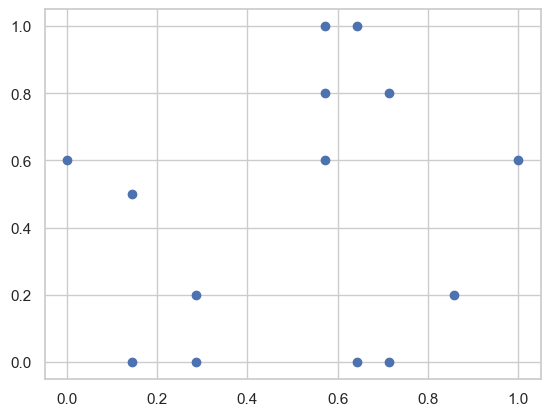

In [37]:
# le résultat du plot est identique au précédent, aux valeurs des axes près.
plt.scatter(X1_values,X2_values)


#### Distances entre exemples

<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>dist_euclidienne</code> qui prend en argument deux exemples sous la forme de vecteurs (Dataframe ou np.array) et rend leur distance euclidienne. 

In [39]:
v1= data_2D_norm.iloc[0]
v2= data_2D_norm.iloc[1]
print("v1 : ",v1, "\nv2 : ",v2)
print("distance euclidienne entre v1 et v2 : ", dist_euclidienne(v1,v2))

v1 :  X1    0.0
X2    0.6
Name: 0, dtype: float64 
v2 :  X1    0.142857
X2    0.500000
Name: 1, dtype: float64
distance euclidienne entre v1 et v2 :  0.17437936593905287


In [40]:
# Remarque : si elle est bien écrite, la fonction doit fonctionner aussi pour un np.array:

v1= np.array(data_2D_norm.iloc[0])
v2= np.array(data_2D_norm.iloc[1])
print("v1 : ",v1, "\nv2 : ",v2)
print("distance euclidienne entre v1 et v2 : ", dist_euclidienne(v1,v2))

v1 :  [0.  0.6] 
v2 :  [0.14285714 0.5       ]
distance euclidienne entre v1 et v2 :  0.17437936593905287


In [41]:
# autre exemples:
v3= np.array([0,0,0])
v4= np.array([1,1,1])
print("v3 : ",v3, "\nv4 : ",v4)
print("distance euclidienne entre v3 et v4 : ", dist_euclidienne(v3,v4))
v5= np.array([0,0,0])
v6= np.array([-1,0,1])
print("v5 : ",v5, "\nv6 : ",v6)
print("distance euclidienne entre v5 et v6 : ", dist_euclidienne(v5,v6))

v3 :  [0 0 0] 
v4 :  [1 1 1]
distance euclidienne entre v3 et v4 :  1.7320508075688772
v5 :  [0 0 0] 
v6 :  [-1  0  1]
distance euclidienne entre v5 et v6 :  1.4142135623730951


#### Calcul de centroides

<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>centroide</code> qui, étant donné un dataframe (ou un np.array) contenant plusieurs exemples rend leur centre de gravité (centroide).
On fait l'hypothèse qu'il y a toujours au moins un exemple.


In [43]:
centroide(data_2D_norm)

X1    0.510204
X2    0.450000
dtype: float64

In [44]:
# Remarque : si elle est bien écrite, la fonction doit fonctionner aussi pour un np.array:
centroide( np.array(data_2D_norm) )

array([0.51020408, 0.45      ])

#### Distances entre groupes d'exemples (approche centroides)


La distance entre deux groupes d'exemples correspond à la distance entre leurs centroïdes (approche "centroid linkage"). Pour cette approche, on prendra seulement la distance euclidienne.

<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>dist_centroides</code> qui prend en argument deux groupes de vecteurs (dataframe ou np.array) et qui rend leur distance euclidienne.


In [46]:
# Par exemple:
dist_centroides(data_2D_norm.iloc[0:4],data_2D_norm.iloc[5:13])

0.586345478713841

####  l'algorithme de classification hiérarchique

Dans la suite de cet exercice, une partition (qui est un groupe de clusters) est représentée par une structure de données de type dictionnaire (c'est à dire <code>dict()</code>) :
- la clé est un numéro de cluster (sous la forme d'un entier naturel) ;
- la valeur associée est un liste contenant les indices des exemples qui sont dans le cluster correspondant.

Les indices sont ceux du dataframe qui contient la base initiale.

<b>Dans ce qui suit, on appelle "partition" un tel dictionnaire.</b>


Rappel: `iloc` accepte une liste d'indices pour extraire des lignes d'un dataframe...

In [47]:
data_2D_norm.iloc[[0,3,1]]

,X1,X2
0,0.000000,0.6
3,0.285714,0.0
1,0.142857,0.5


<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>initialise_CHA</code> qui, étant donné un dataframe DF représentant une base d'apprentissage, rend une partition contenant autant d'entrées que d'exemples dans DF. La clé de chaque entrée sera le numéro de l'exemple. Cette fonction sera spécifique au clustering hiérarchique ascendant (CHA).

In [49]:
# Par exemple:
depart = initialise_CHA(data_2D_norm)
depart

{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [9],
 10: [10],
 11: [11],
 12: [12],
 13: [13]}

#### Variante 1: chaînage par centroides

On souhaite implémenter ici l'algorithme de classification hiérarchique basé sur l'approche "centroid linkage".

On commence par implémenter une fonction qui, étant donné une partition, permet de regrouper les 2 clusters les plus proches. Ces 2 clusters sont alors fusionnés pour n'en former qu'un seul qui est ajouté à la partition, alors que les 2 clusters initiaux sont retirés de la partition.

On fait l'hypothèse que la partition initiale contient au moins 2 groupes.

<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>fusionne</code> qui prend en argument un dataframe contenant des exemples et une partition P0 et qui rend le tuple composé des 4 valeurs suivantes:
- la partition P1 obtenue après fusion des 2 clusters de P0 les plus proches ;
- les clés des 2 clusters de P0 qui ont été fusionnés et qui ne sont donc plus dans P1 ;
- la distance qui séparait ces 2 clusters, calculée selon le nom de distance donné.

Vous rajouterez un troisième argument (avec valeur par défaut) à la fonction : `verbose=False` qui indique si des messages doivent être affichés pour expliquer ce que fait la fonctionne. Les messages doivent tous commencer par "fusionne:".

In [51]:
# Exemple:
fusionne(data_2D_norm, depart)

({0: [0],
  1: [1],
  2: [2],
  3: [3],
  4: [4],
  5: [5],
  6: [6],
  7: [7],
  9: [9],
  11: [11],
  12: [12],
  13: [13],
  14: [8, 10]},
 8,
 10,
 0.0714285714285714)

In [52]:
# Exemple avec verbose:
fusionne(data_2D_norm, depart,verbose=True)

fusionne: distance mininimale trouvée entre  [8, 10]  =  0.0714285714285714
fusionne: les 2 clusters dont les clés sont  [8, 10]  sont fusionnés
fusionne: on crée la  nouvelle clé 14  dans le dictionnaire.
fusionne: les clés de  [8, 10]  sont supprimées car leurs clusters ont été fusionnés.


({0: [0],
  1: [1],
  2: [2],
  3: [3],
  4: [4],
  5: [5],
  6: [6],
  7: [7],
  9: [9],
  11: [11],
  12: [12],
  13: [13],
  14: [8, 10]},
 8,
 10,
 0.0714285714285714)

<font size="+1" color="RED"><b>[Q]</b></font> Ecrire la fonction <code>CHA_centroid</code> qui prend en argument un dataframe et rend une liste composée de listes contenant chacune:
- les 2 indices d'éléments fusionnés
- la distance les séparant
- la somme du nombre d'éléments des 2 éléments fusionnés

Comme pour la fonction précédente, vous rajouterez un argument `verbose=False` pour gérer l'affichage de messages lors de l'exécution de la fonction (et de la fonction précédente qu'elle appelle). Les messages de cette fonction commencent par "CHA_centroid:".

Remarque: chaque sous-liste contient donc les 3 dernières valeurs du résultats de `fusionne()`.


In [54]:
# L'application sur nos données:
CHA_centroid(data_2D_norm)

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.20316375219039837, 4],
 [4, 16, 0.21237241067597867, 3],
 [12, 14, 0.26811891970176366, 3],
 [5, 19, 0.3047456282855976, 5],
 [13, 22, 0.4542857142857144, 6],
 [20, 21, 0.5000000000000001, 6],
 [18, 24, 0.638139657302555, 8],
 [23, 25, 0.6796842379114776, 14]]

In [55]:
# L'application sur nos données avec verbose à True
CHA_centroid(data_2D_norm,True)

CHA_centroid: clustering hiérarchique ascendant, version Centroid Linkage
fusionne: distance mininimale trouvée entre  [8, 10]  =  0.0714285714285714
fusionne: les 2 clusters dont les clés sont  [8, 10]  sont fusionnés
fusionne: on crée la  nouvelle clé 14  dans le dictionnaire.
fusionne: les clés de  [8, 10]  sont supprimées car leurs clusters ont été fusionnés.
CHA_centroid: une fusion réalisée de  8  avec  10 de distance  0.0714
CHA_centroid: le nouveau cluster contient  2  exemples
fusionne: distance mininimale trouvée entre  [7, 9]  =  0.07142857142857151
fusionne: les 2 clusters dont les clés sont  [7, 9]  sont fusionnés
fusionne: on crée la  nouvelle clé 15  dans le dictionnaire.
fusionne: les clés de  [7, 9]  sont supprimées car leurs clusters ont été fusionnés.
CHA_centroid: une fusion réalisée de  7  avec  9 de distance  0.0714
CHA_centroid: le nouveau cluster contient  2  exemples
fusionne: distance mininimale trouvée entre  [2, 3]  =  0.14285714285714285
fusionne: les 2 clu

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.20316375219039837, 4],
 [4, 16, 0.21237241067597867, 3],
 [12, 14, 0.26811891970176366, 3],
 [5, 19, 0.3047456282855976, 5],
 [13, 22, 0.4542857142857144, 6],
 [20, 21, 0.5000000000000001, 6],
 [18, 24, 0.638139657302555, 8],
 [23, 25, 0.6796842379114776, 14]]

#### Construction de dendrogramme

Le dendrogramme permet de visualiser les fusions de clusters réalisés tout au long du déroulement de l'algorithme de clustering hiérarchique.

Pour cette représentation graphique, on utilise une fonction de la librairie `scipy`.

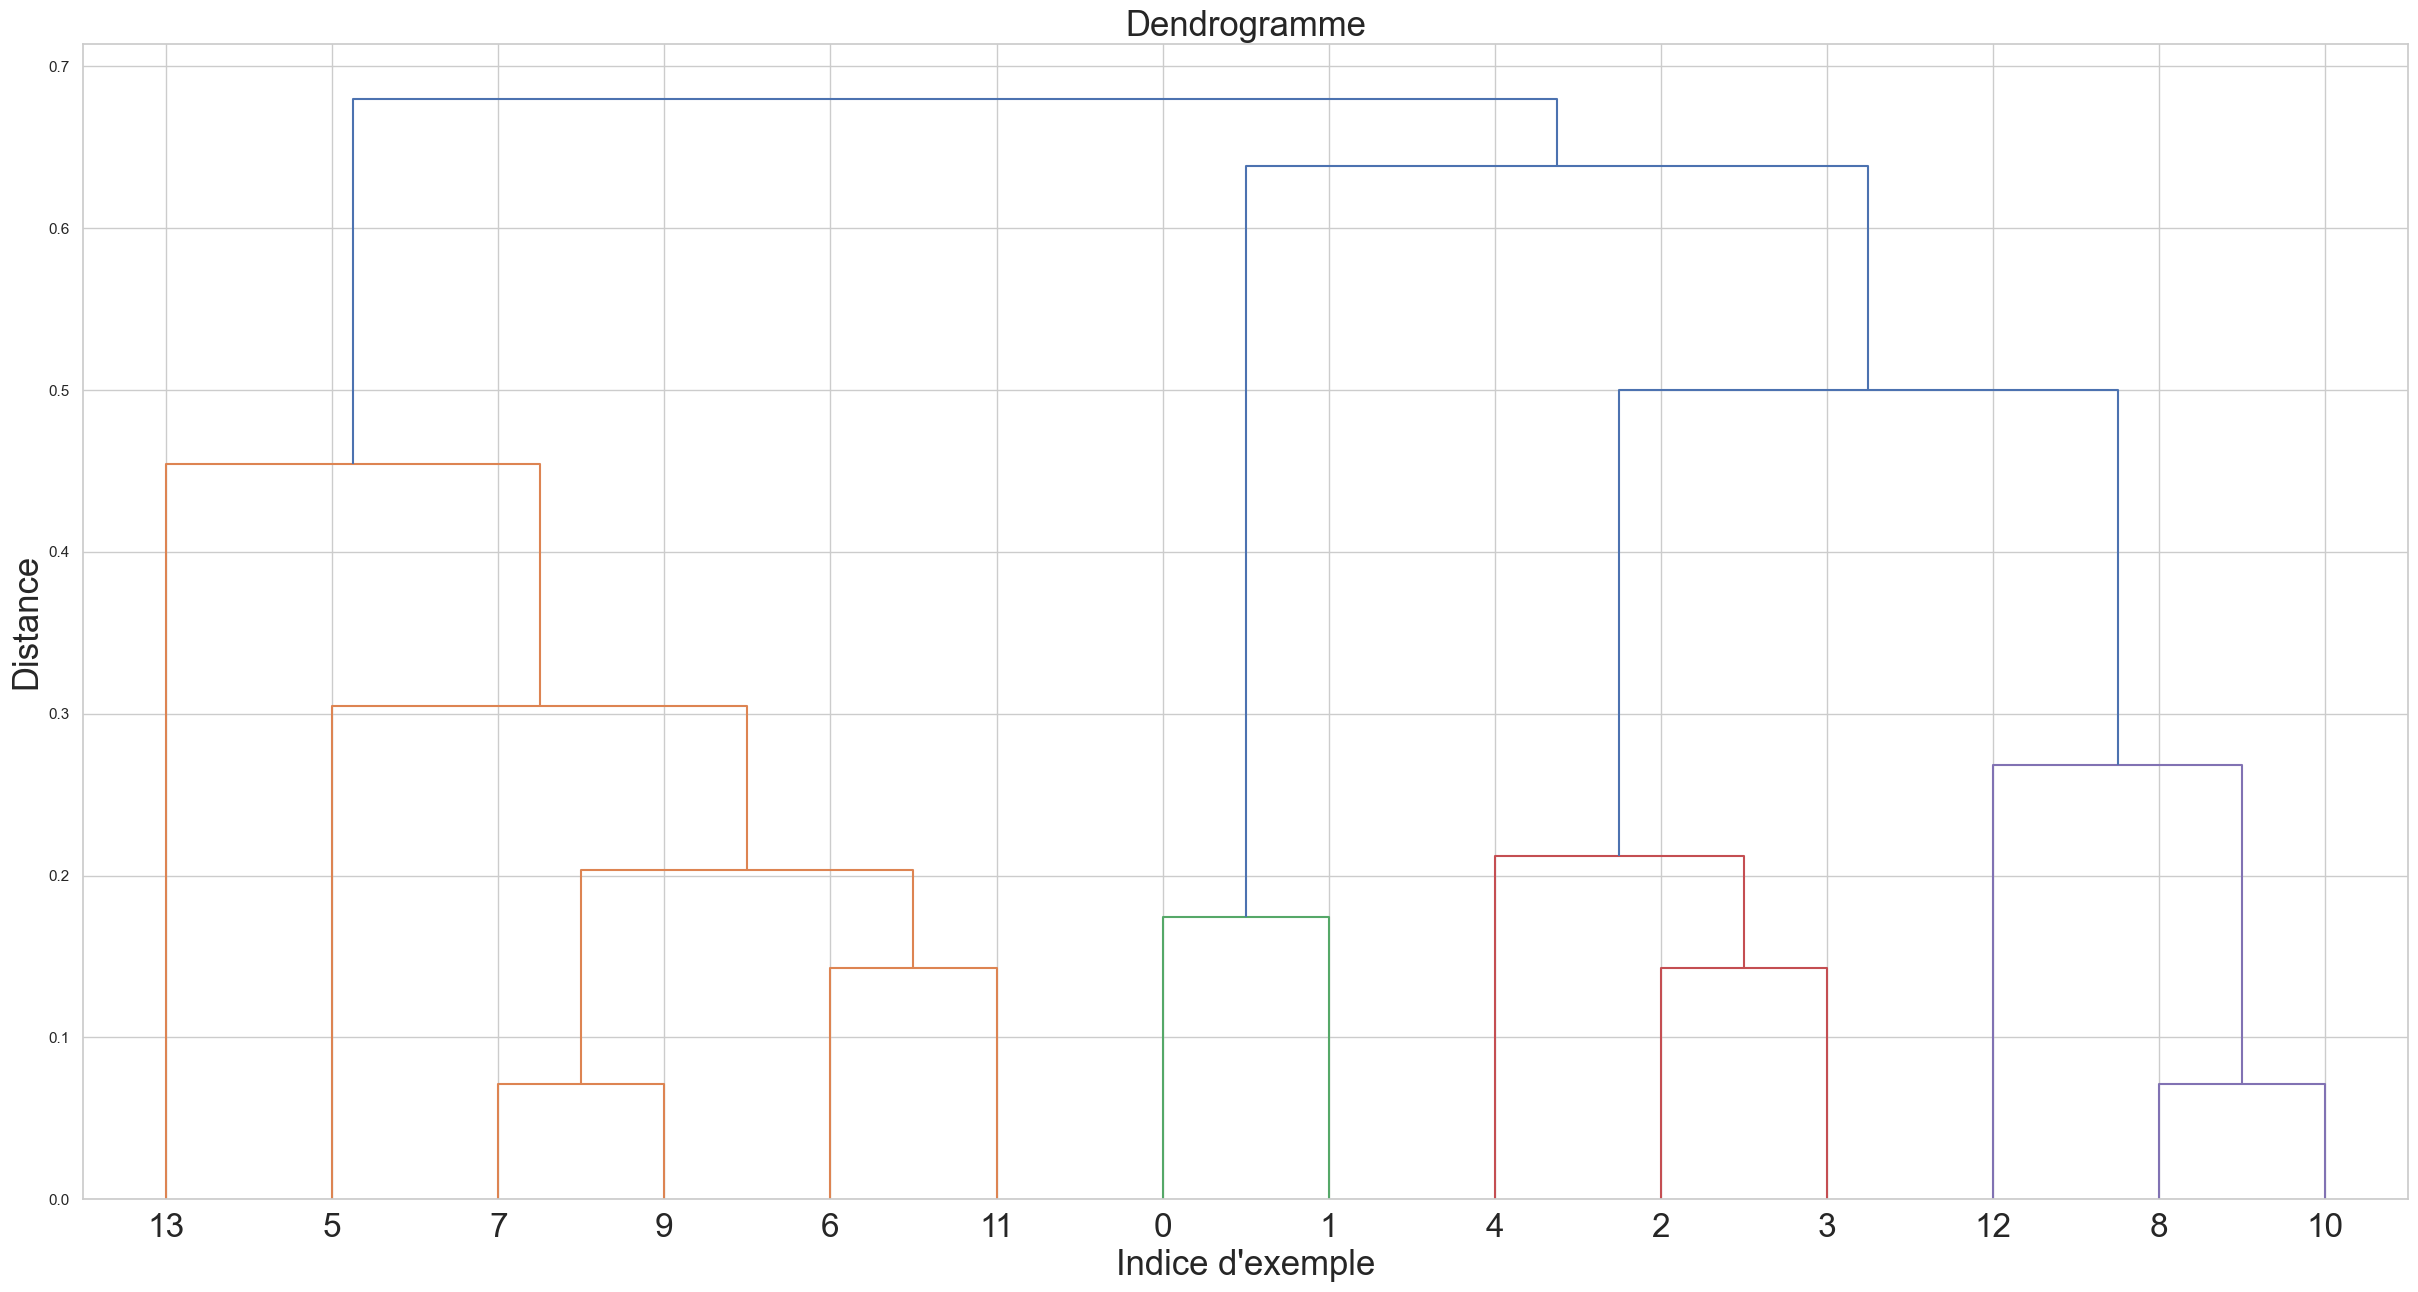

In [56]:
import scipy.cluster.hierarchy

# Paramètre de la fenêtre d'affichage: 
plt.figure(figsize=(30, 15)) # taille : largeur x hauteur
plt.title('Dendrogramme', fontsize=25)    
plt.xlabel("Indice d'exemple", fontsize=25)
plt.ylabel('Distance', fontsize=25)

# Construction du dendrogramme pour notre clustering :
scipy.cluster.hierarchy.dendrogram(
    CHA_centroid(data_2D_norm), 
    leaf_font_size=24.,  # taille des caractères de l'axe des X
)

# Affichage du résultat obtenu:
plt.show()

<font size="+1" color="RED"><b>[Q]</b></font> Modifier la fonction <code>CHA_centroid</code> en lui rajoutant un argument supplémentaire avec valeur par défaut:
- `dendrogramme=False` pour indiquer si on souhaite ou pas l'affichage du dendrogramme résultat. Si c'est le cas, le dendrogramme sera donc afficher à l'issue de la fonction.

In [57]:
import scipy.cluster.hierarchy



In [58]:
CHA_centroid(data_2D_norm)

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.20316375219039837, 4],
 [4, 16, 0.21237241067597867, 3],
 [12, 14, 0.26811891970176366, 3],
 [5, 19, 0.3047456282855976, 5],
 [13, 22, 0.4542857142857144, 6],
 [20, 21, 0.5000000000000001, 6],
 [18, 24, 0.638139657302555, 8],
 [23, 25, 0.6796842379114776, 14]]

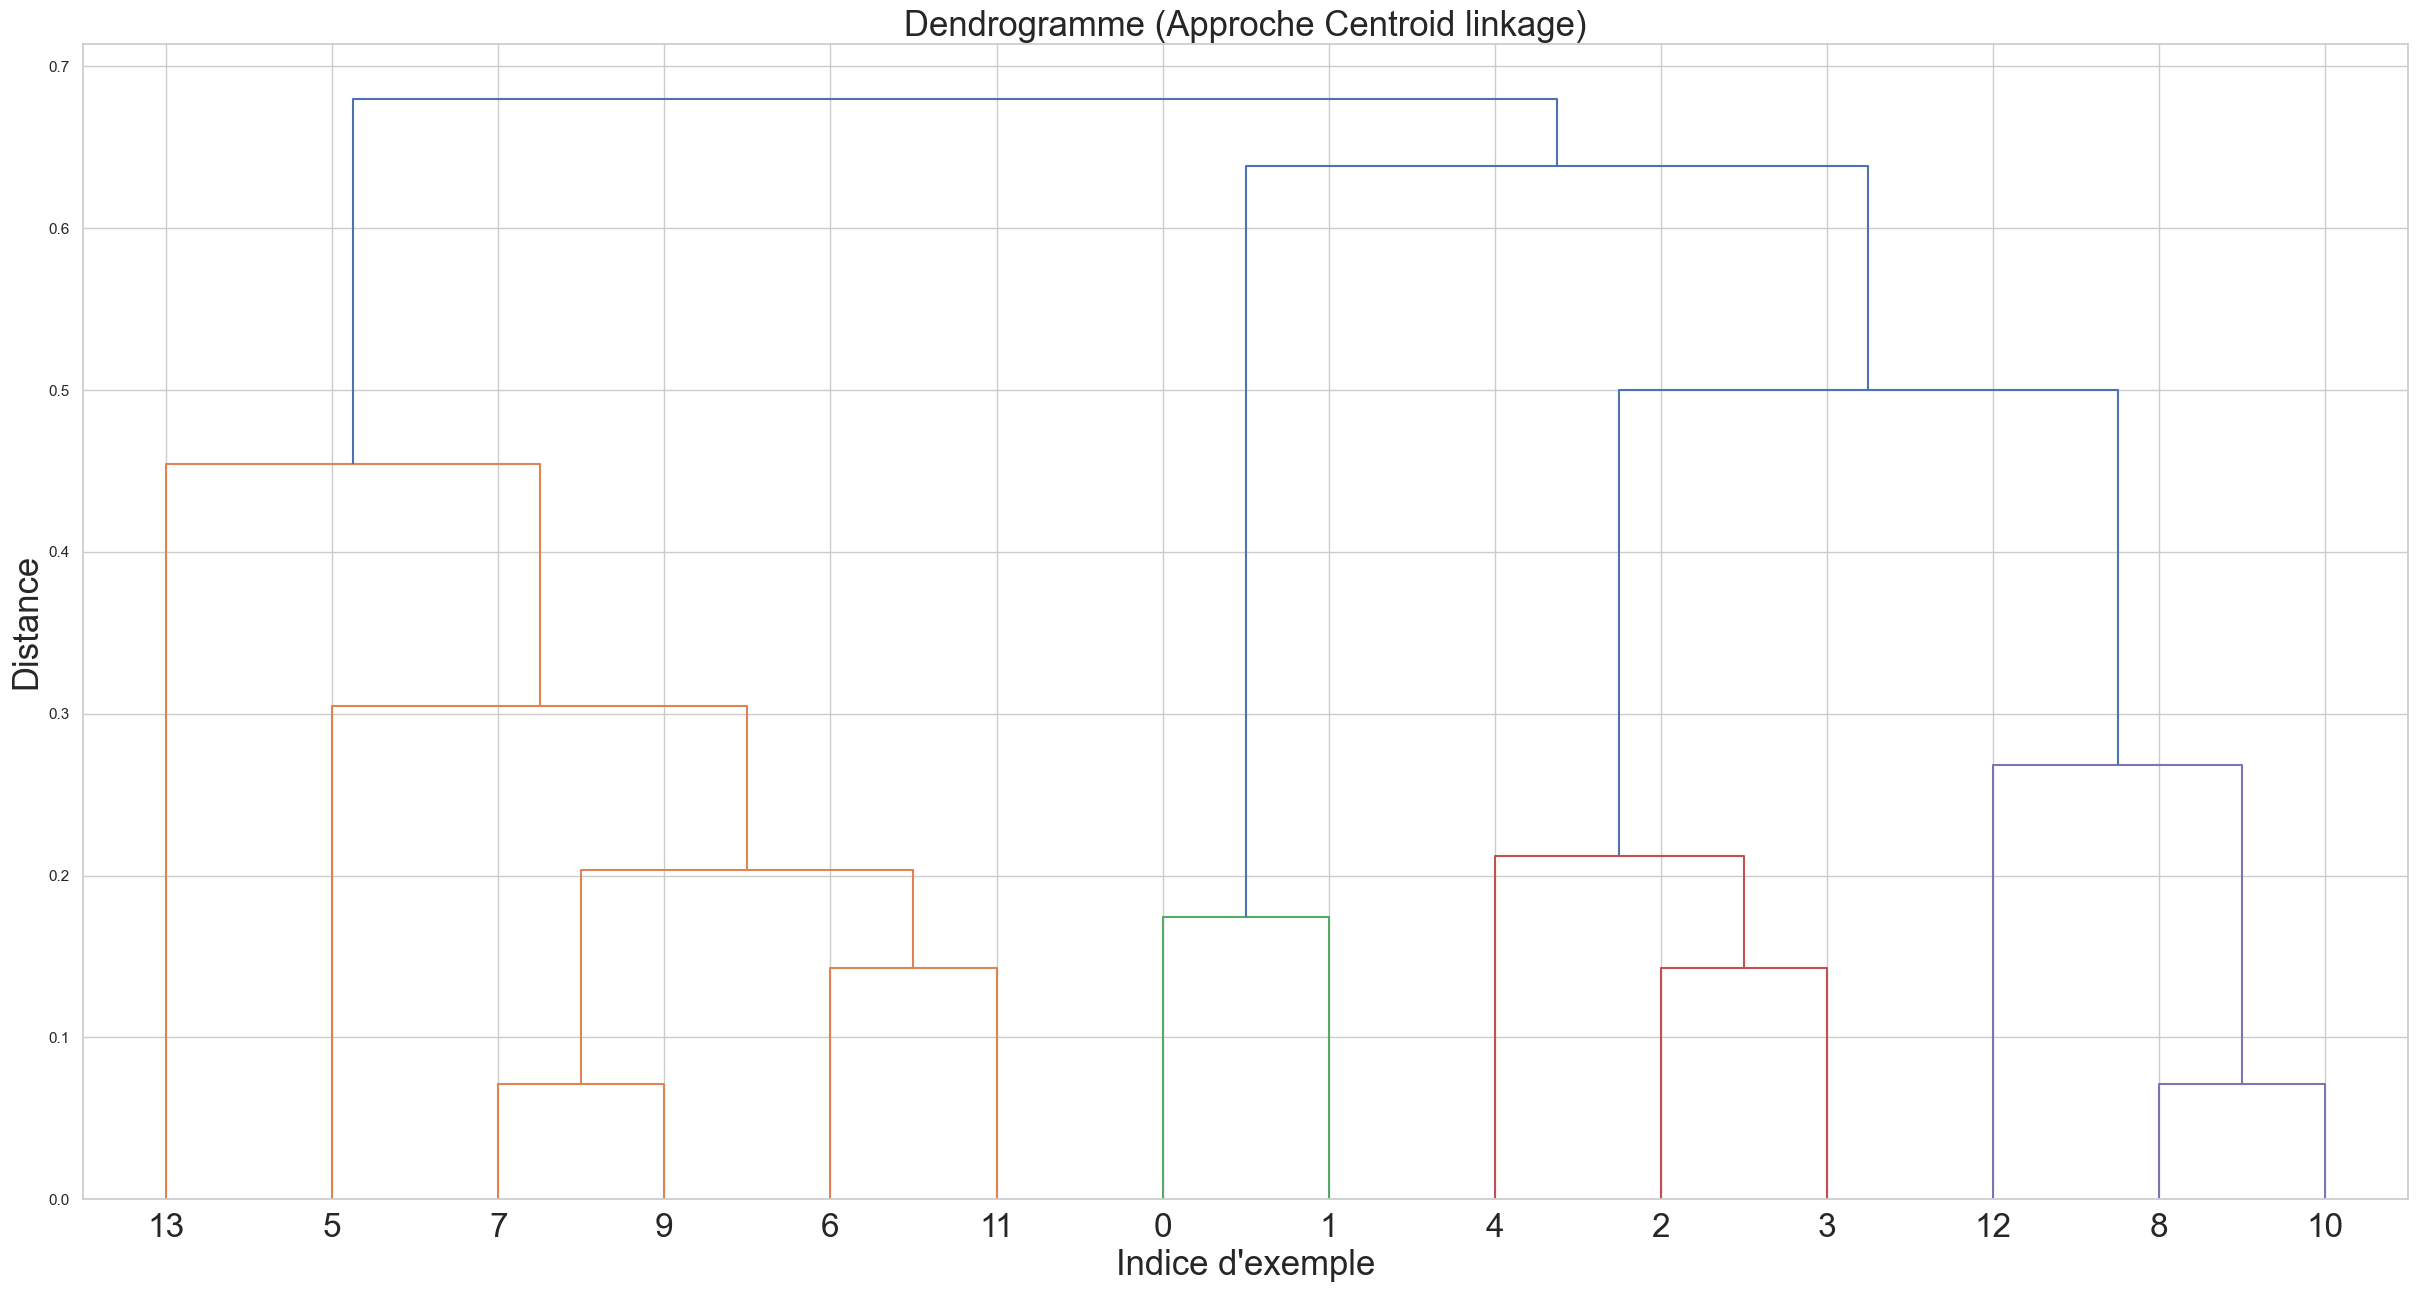

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.20316375219039837, 4],
 [4, 16, 0.21237241067597867, 3],
 [12, 14, 0.26811891970176366, 3],
 [5, 19, 0.3047456282855976, 5],
 [13, 22, 0.4542857142857144, 6],
 [20, 21, 0.5000000000000001, 6],
 [18, 24, 0.638139657302555, 8],
 [23, 25, 0.6796842379114776, 14]]

In [59]:
CHA_centroid(data_2D_norm,dendrogramme=True)

### Variantes : complete linkage, simple linkage, average linkage

<font size="+1" color="RED"><b>[Q]</b></font> Ecrire 3 nouvelles fonctions `CHA_complete`, `CHA_simple` et `CHA_average` qui implémentent le clustering hiérarchique basé le linkage correspondant.


Puis afficher et comparer les dendrogrammes obtenus par les 4 approches de clustering implémentées.

In [61]:
G1df = data_2D_norm.iloc[0:4]
G2df = data_2D_norm.iloc[5:13]
G1 = np.array(G1df)
G2 = np.array(G2df)
G1df

,X1,X2
0,0.000000,0.6
1,0.142857,0.5
2,0.142857,0.0
3,0.285714,0.0


In [62]:
G2df

,X1,X2
5,0.571429,0.6
6,0.571429,0.8
7,0.571429,1.0
8,0.642857,0.0
9,0.642857,1.0
10,0.714286,0.0
11,0.714286,0.8
12,0.857143,0.2


In [63]:
for i in range(0,G2.shape[0]):
    print(i, " ==> ", np.sqrt(np.sum((G1 - G2[i])**2,axis=1)), np.max(np.sqrt(np.sum((G1 - G2[i])**2,axis=1))), np.argmax(np.sqrt(np.sum((G1 - G2[i])**2,axis=1))))

0  ==>  [0.57142857 0.44008348 0.73734217 0.66455448] 0.7373421657465108 2
1  ==>  [0.60541772 0.5231381  0.90756458 0.84948964] 0.9075645813867766 2
2  ==>  [0.69751746 0.65853889 1.08796759 1.0400157 ] 1.0879675865519869 2
3  ==>  [0.87935505 0.70710678 0.5        0.35714286] 0.8793550512292796 0
4  ==>  [0.75714286 0.70710678 1.11803399 1.06186205] 1.118033988749895 2
5  ==>  [0.9328473  0.75929613 0.57142857 0.42857143] 0.9328472981322575 0
6  ==>  [0.74175743 0.64539183 0.98312289 0.90756458] 0.9831228876620145 2
7  ==>  [0.94588259 0.77472839 0.74175743 0.60541772] 0.945882591842677 0


In [64]:
dist_complete(data_2D_norm.iloc[0:4],data_2D_norm.iloc[5:13])

(1.118033988749895, (4, 2))

In [65]:
dist_simple(data_2D_norm.iloc[0:4],data_2D_norm.iloc[5:13])

(0.3571428571428572, (3, 3))

In [66]:
dist_centroides(data_2D_norm.iloc[0:4],data_2D_norm.iloc[5:13])

0.586345478713841

In [67]:
dist_average(data_2D_norm.iloc[0:4],data_2D_norm.iloc[5:13])

(0.7471429694932865, 32)

<font size="+1" color="RED"><b>[Q]</b></font> Regrouper les 4 fonctions de clustering hiérarchique ascendant en écrivant une fonction `CHA` qui prend les mêmes arguments que chacune des 4 fonctions précédentes, et un argument suplémentaire `linkage`, qui est une chaîne de caractères parmi `"centroid"` (valeur par défaut),  `"complete"`,`"simple"`, et `"average"` et qui donne le nom de l'approche linkage à utiliser pour construire le clustering.

In [70]:
def CHA(DF,linkage='centroid', verbose=False,dendrogramme=False):
    """  ##### donner une documentation à cette fonction
    """
    ############################ A COMPLETER

    raise NotImplementedError("Please Implement this method")


    

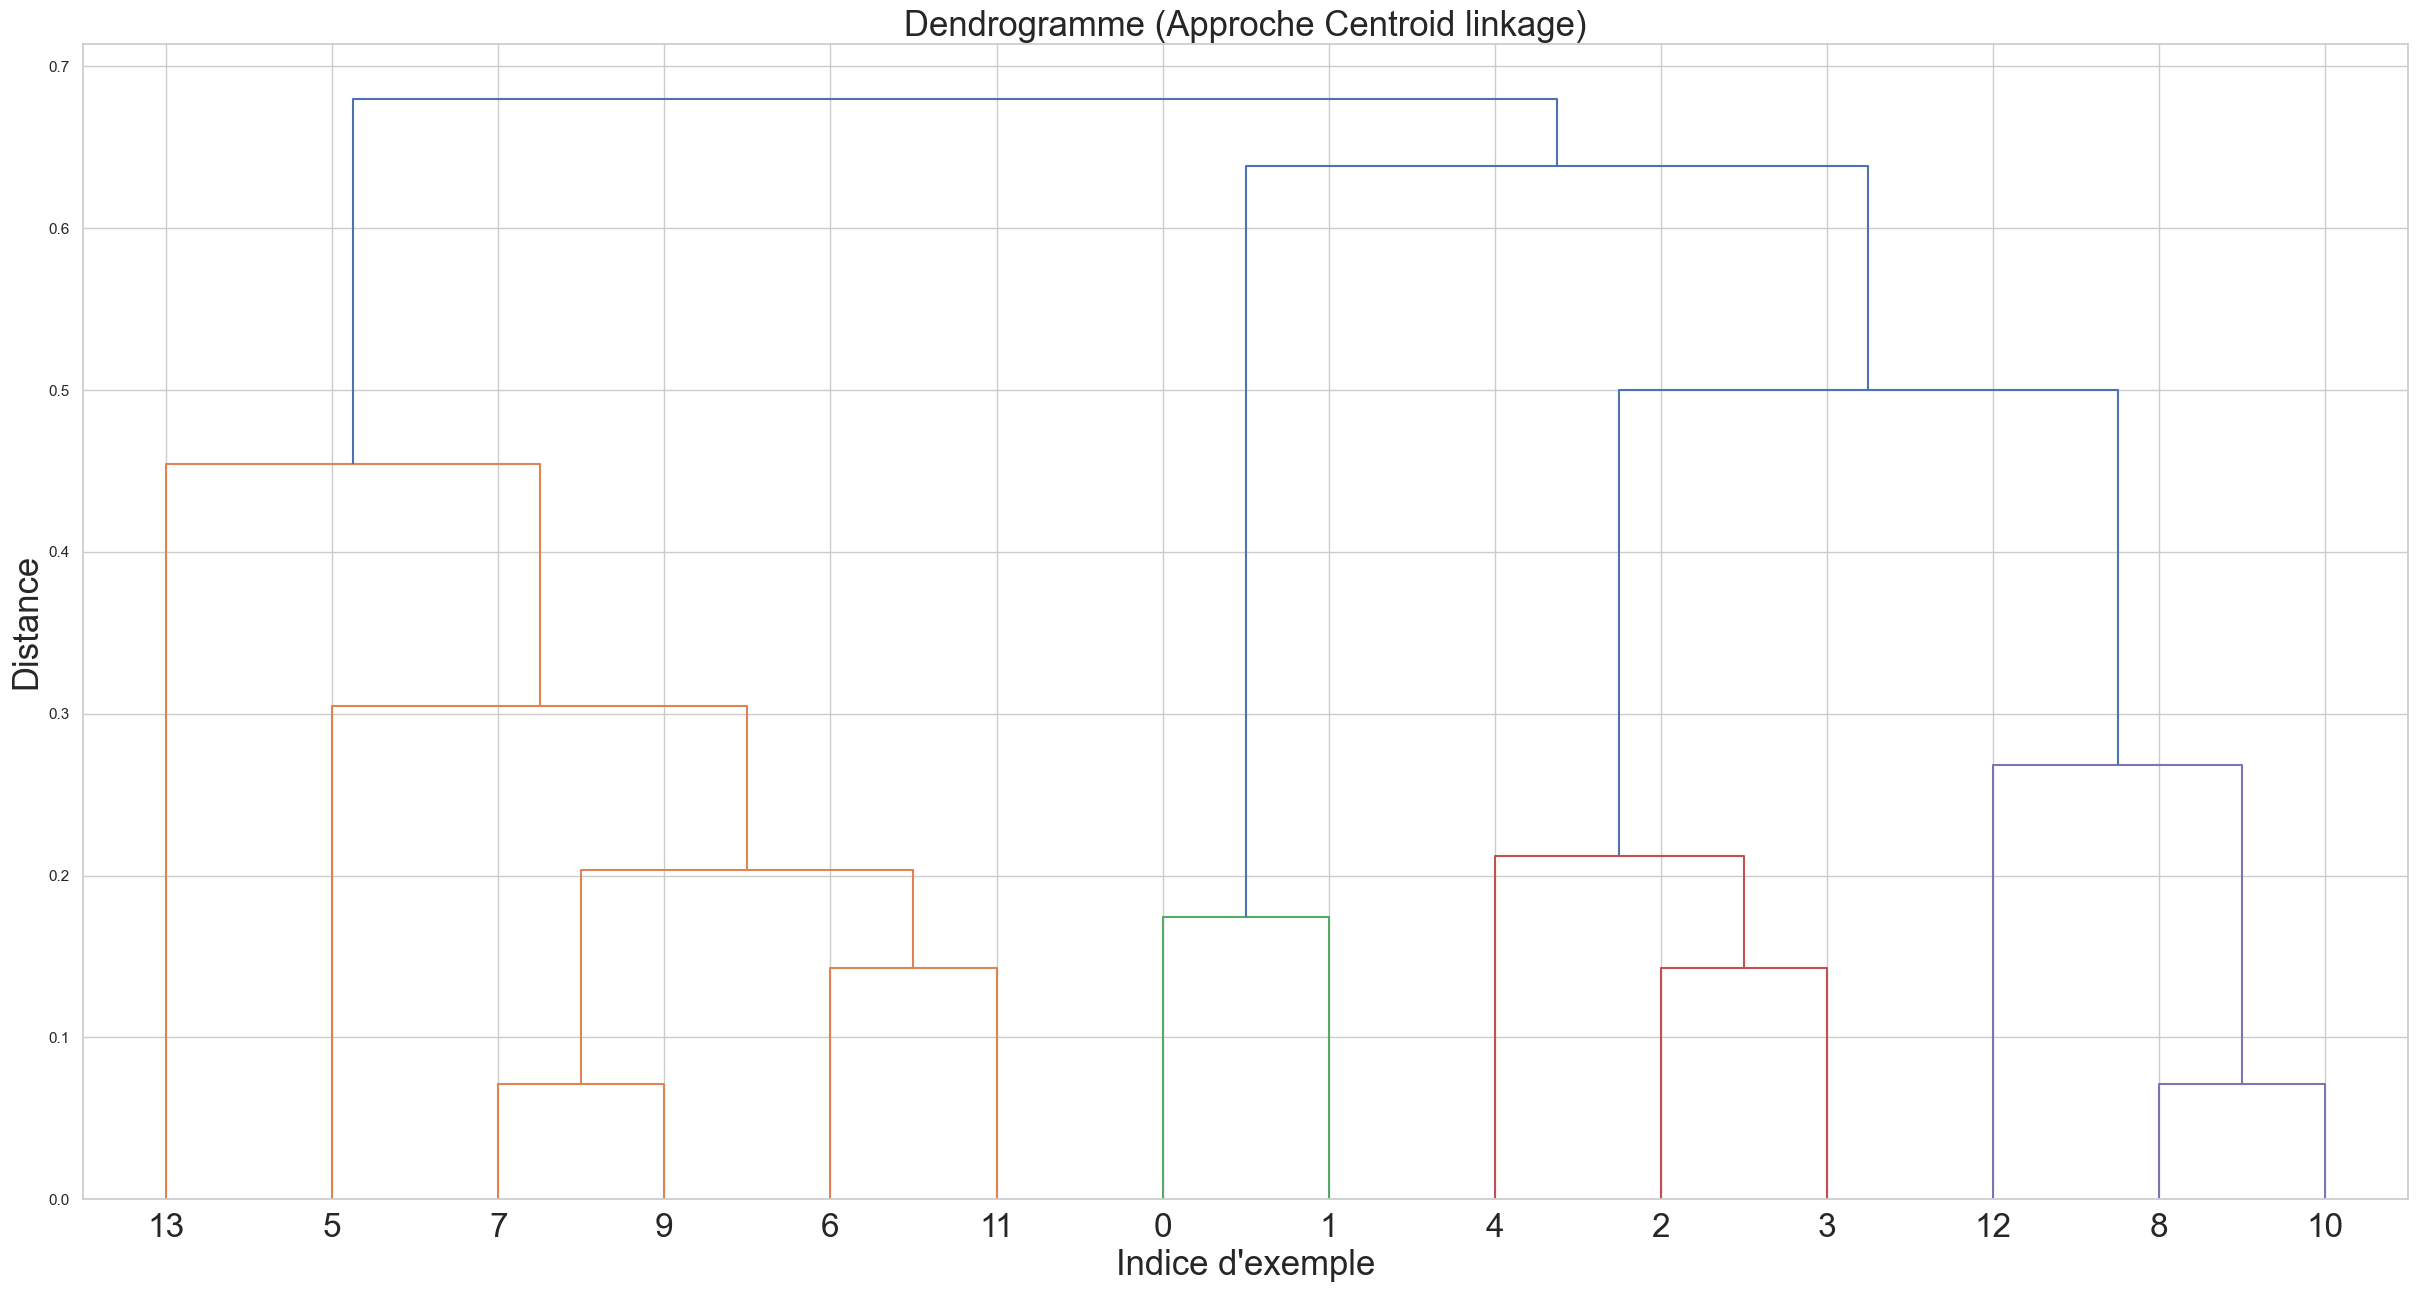

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.20316375219039837, 4],
 [4, 16, 0.21237241067597867, 3],
 [12, 14, 0.26811891970176366, 3],
 [5, 19, 0.3047456282855976, 5],
 [13, 22, 0.4542857142857144, 6],
 [20, 21, 0.5000000000000001, 6],
 [18, 24, 0.638139657302555, 8],
 [23, 25, 0.6796842379114776, 14]]

In [72]:
CHA(data_2D_norm,linkage='centroid',dendrogramme=True)

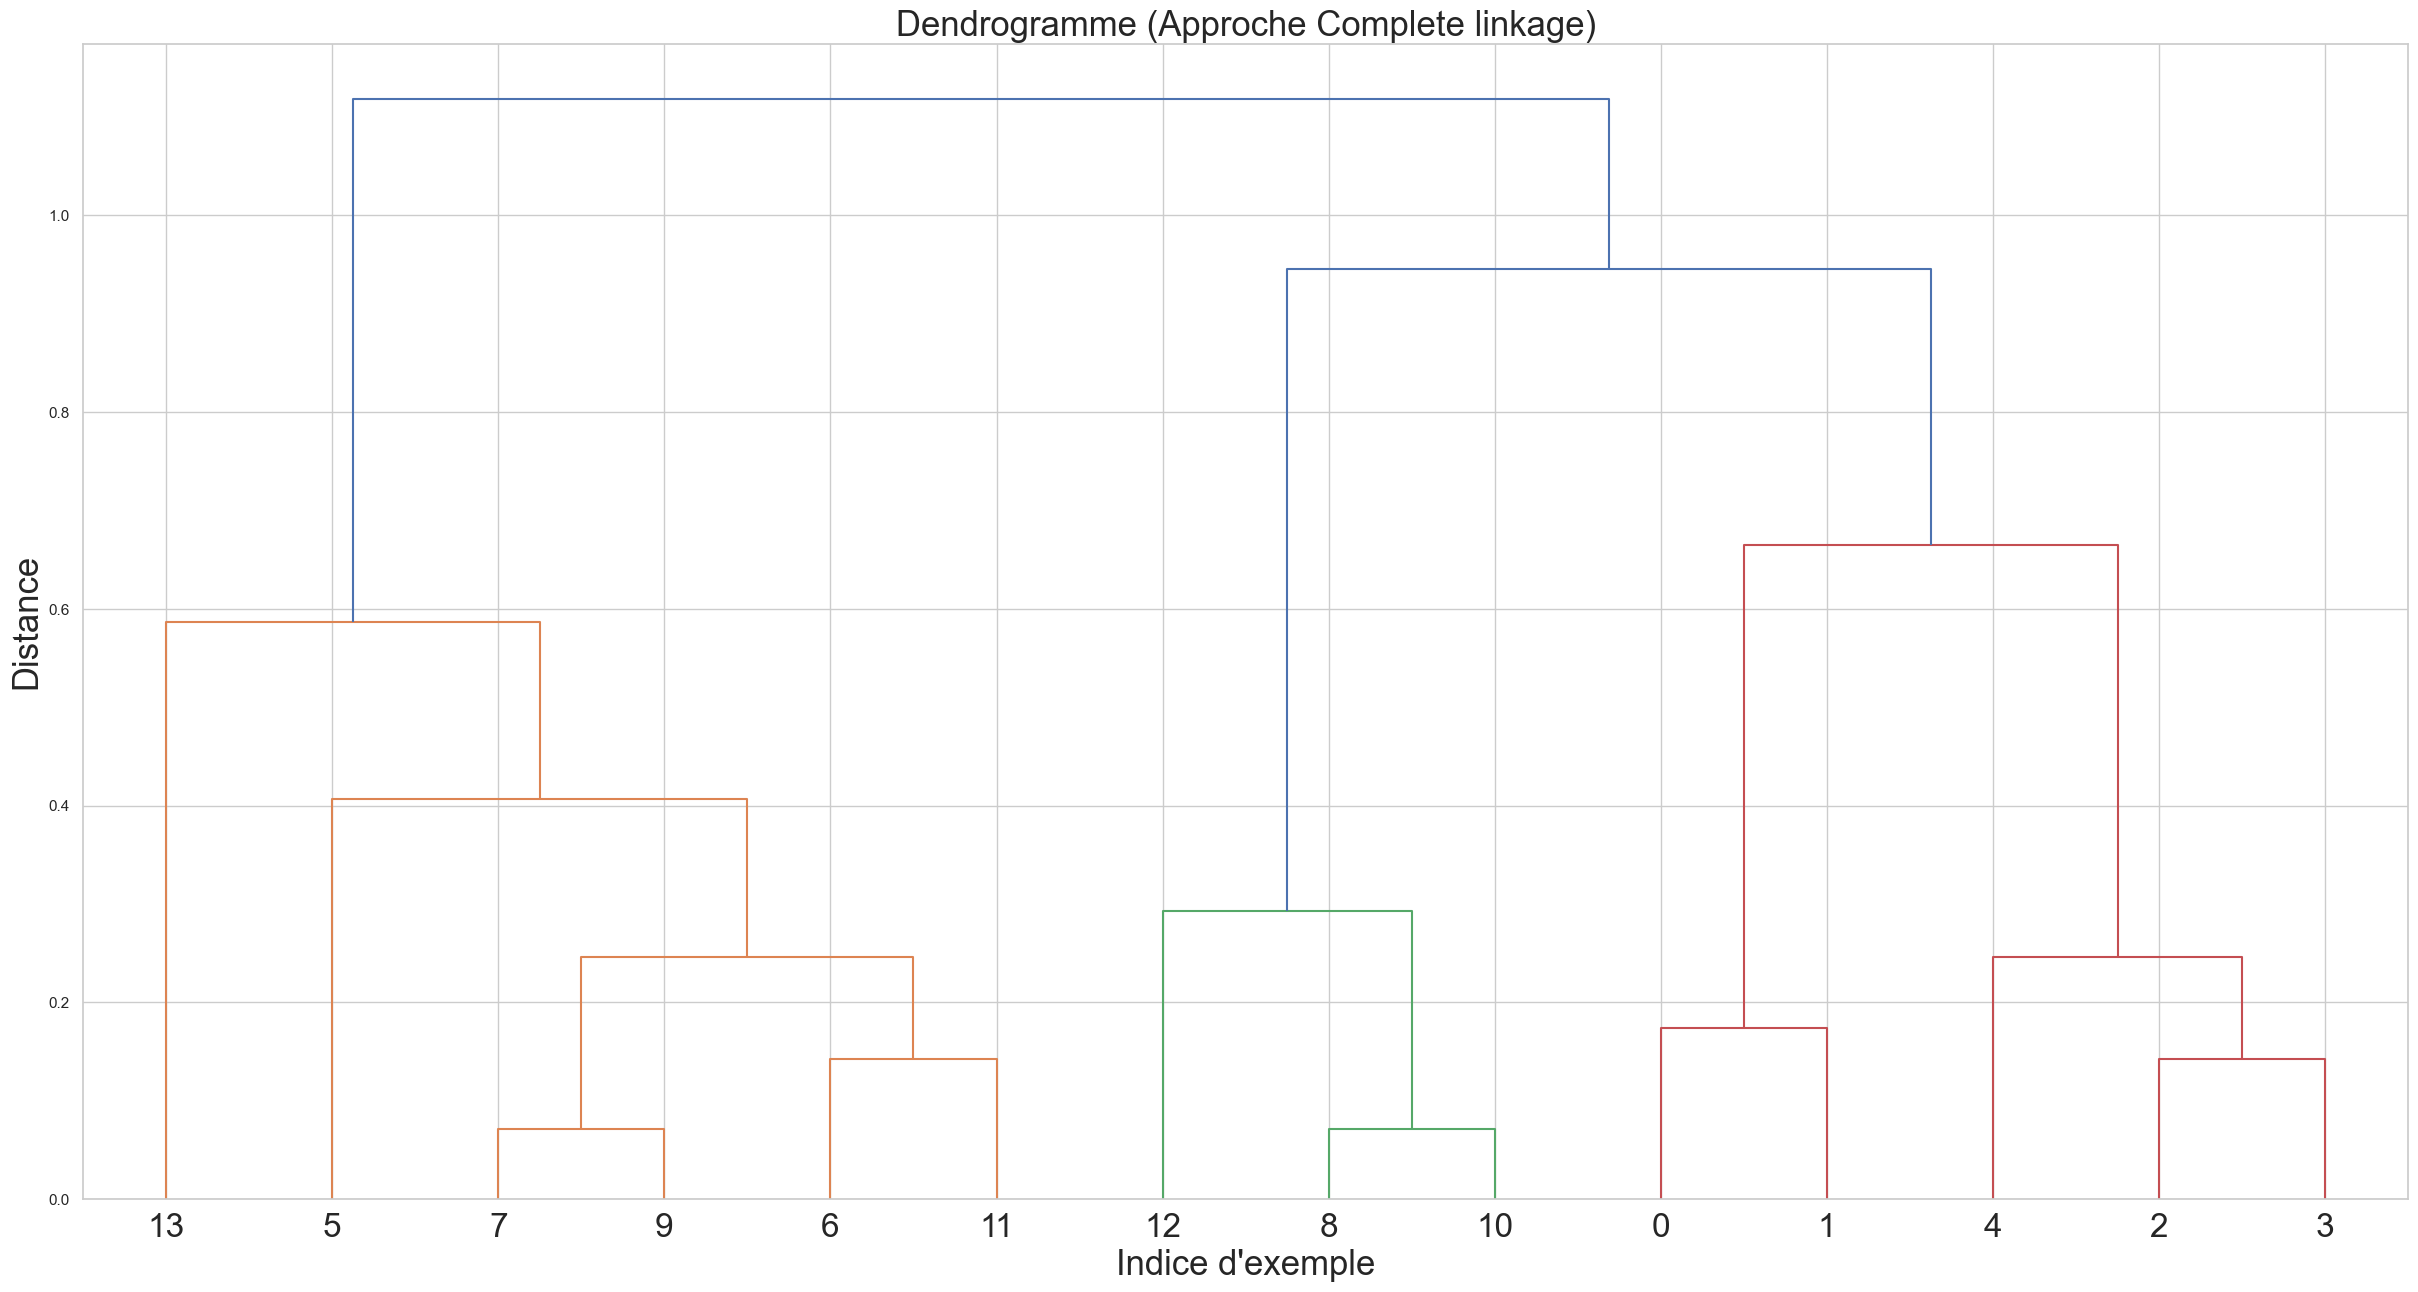

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.2457807219155036, 4],
 [4, 16, 0.24578072191550362, 3],
 [12, 14, 0.2931183504097598, 3],
 [5, 19, 0.40632750438079696, 5],
 [13, 22, 0.5862367008195198, 6],
 [18, 20, 0.6645544771207432, 5],
 [21, 24, 0.945882591842677, 8],
 [23, 25, 1.118033988749895, 14]]

In [73]:
CHA(data_2D_norm,linkage='complete',dendrogramme=True)

Clustering Hiérarchique Ascendant : approche  simple
Clustering hiérarchique ascendant, version Simple Linkage
Distance mininimale trouvée entre  [8, 10]  =  0.0714285714285714
Distance mininimale trouvée entre  [7, 9]  =  0.07142857142857151
Distance mininimale trouvée entre  [2, 3]  =  0.14285714285714285
Distance mininimale trouvée entre  [6, 11]  =  0.1428571428571429
Distance mininimale trouvée entre  [0, 1]  =  0.17437936593905287
Distance mininimale trouvée entre  [15, 17]  =  0.19999999999999996
Distance mininimale trouvée entre  [4, 16]  =  0.2
Distance mininimale trouvée entre  [5, 19]  =  0.20000000000000007
Distance mininimale trouvée entre  [12, 14]  =  0.2457807219155036
Distance mininimale trouvée entre  [18, 20]  =  0.3322772385603716
Distance mininimale trouvée entre  [13, 21]  =  0.3487587318781058
Distance mininimale trouvée entre  [22, 23]  =  0.3571428571428572
Distance mininimale trouvée entre  [24, 25]  =  0.4247448213519573


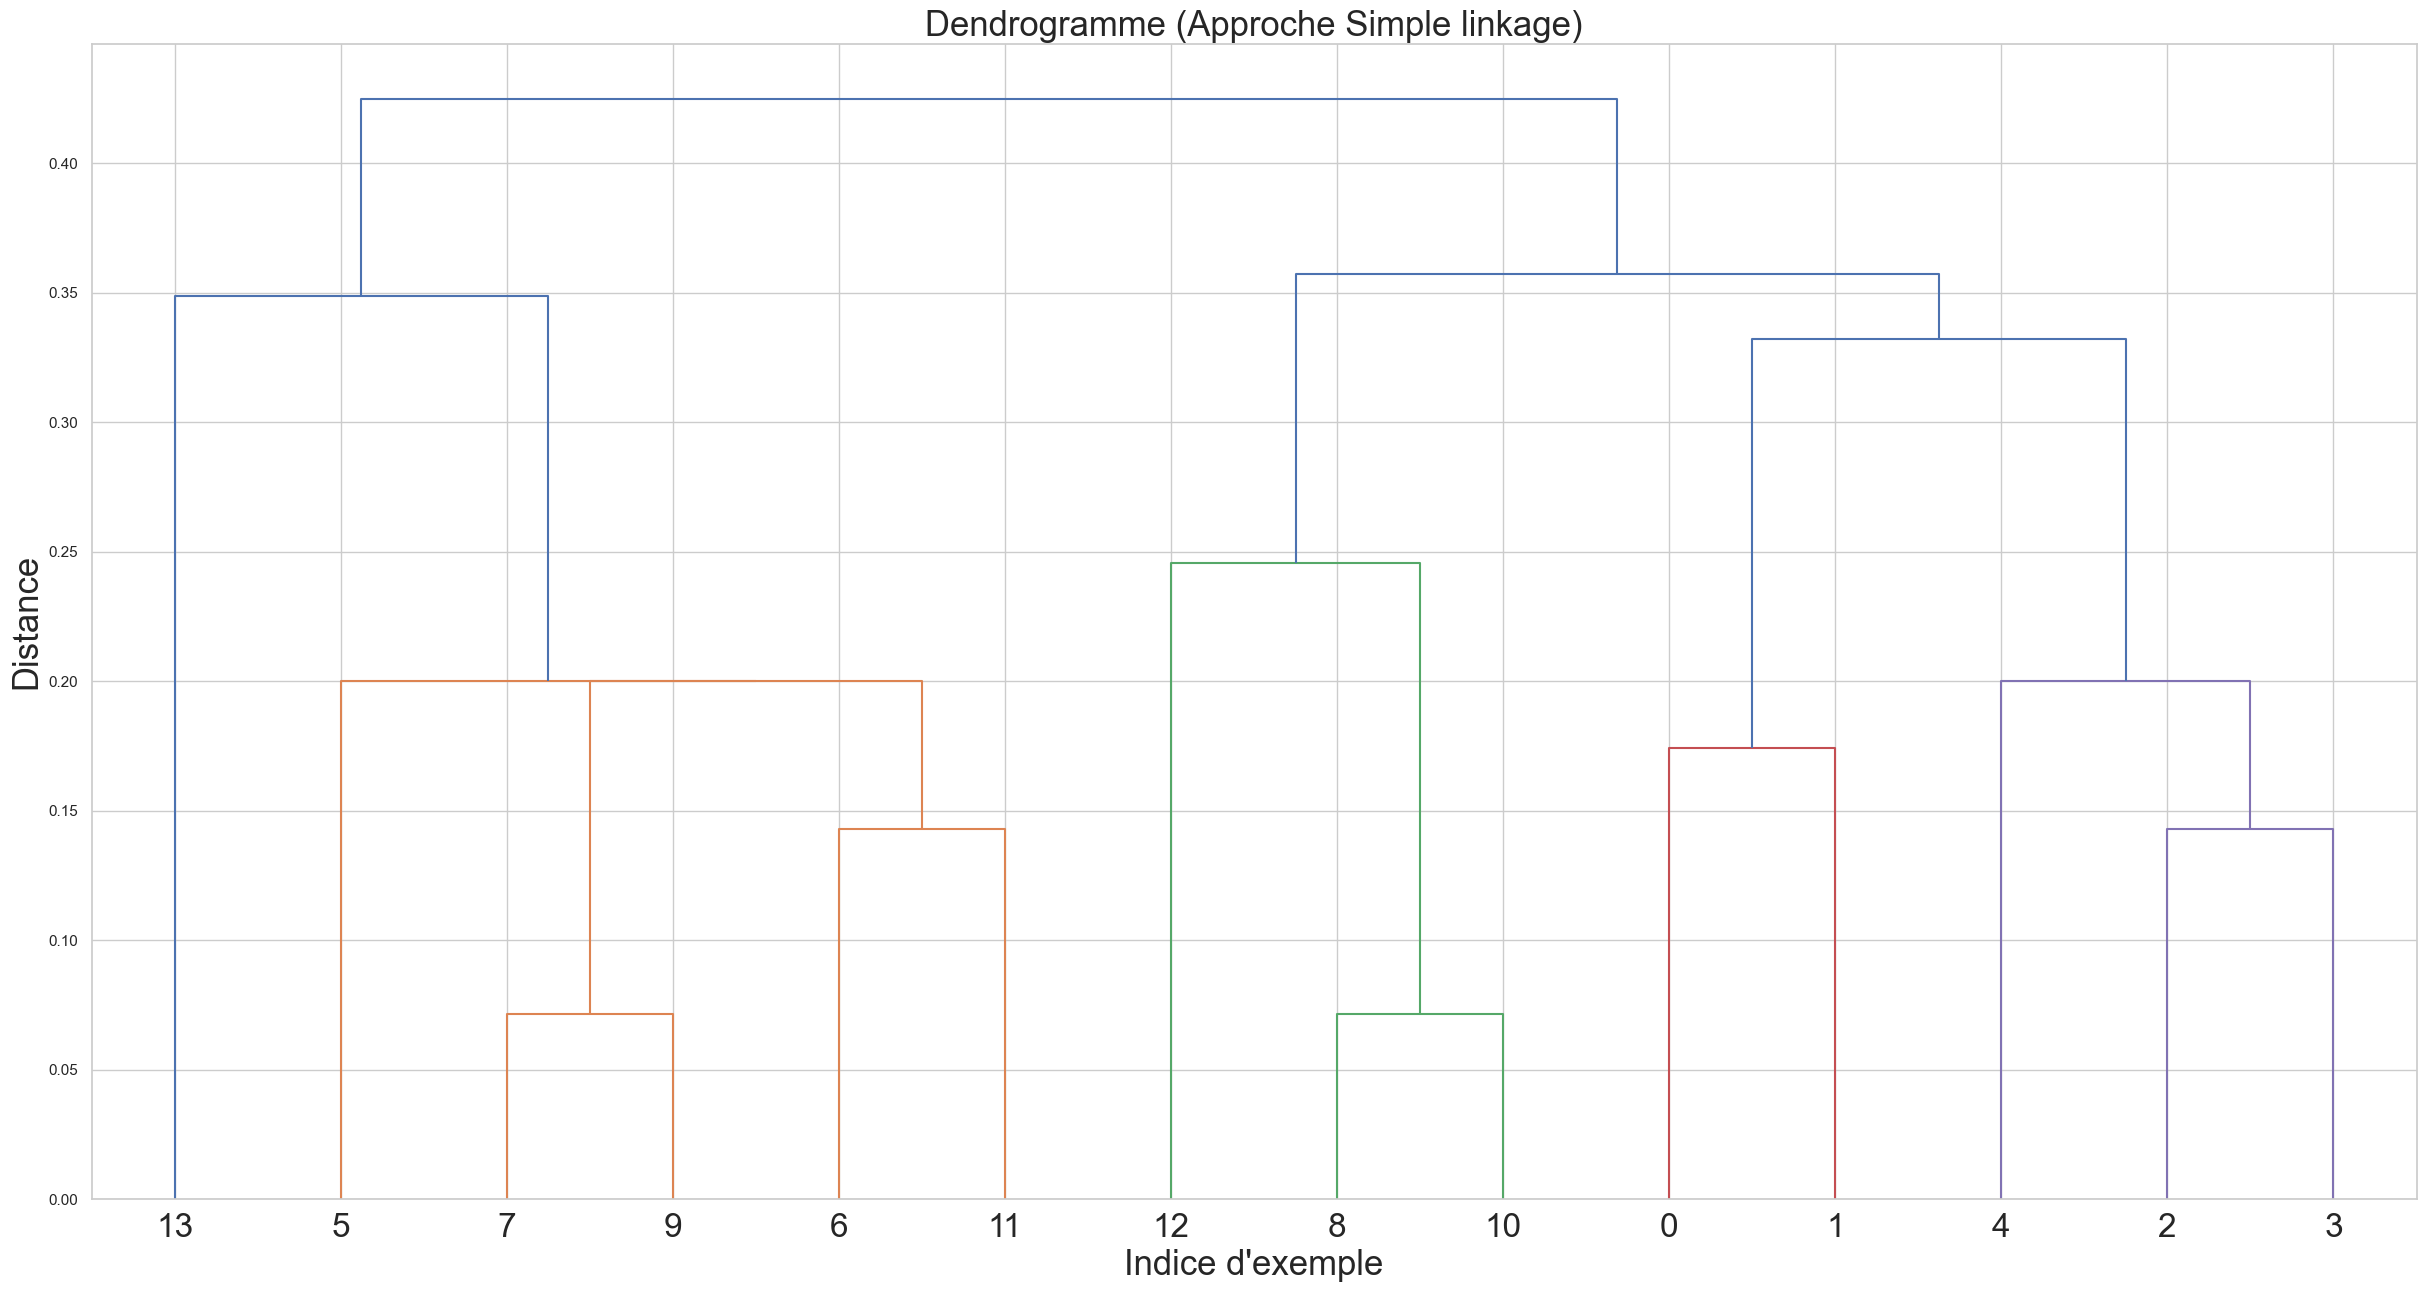

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.19999999999999996, 4],
 [4, 16, 0.2, 3],
 [5, 19, 0.20000000000000007, 5],
 [12, 14, 0.2457807219155036, 3],
 [18, 20, 0.3322772385603716, 5],
 [13, 21, 0.3487587318781058, 6],
 [22, 23, 0.3571428571428572, 8],
 [24, 25, 0.4247448213519573, 14]]

In [74]:
CHA(data_2D_norm,linkage='simple',verbose=True,dendrogramme=True)

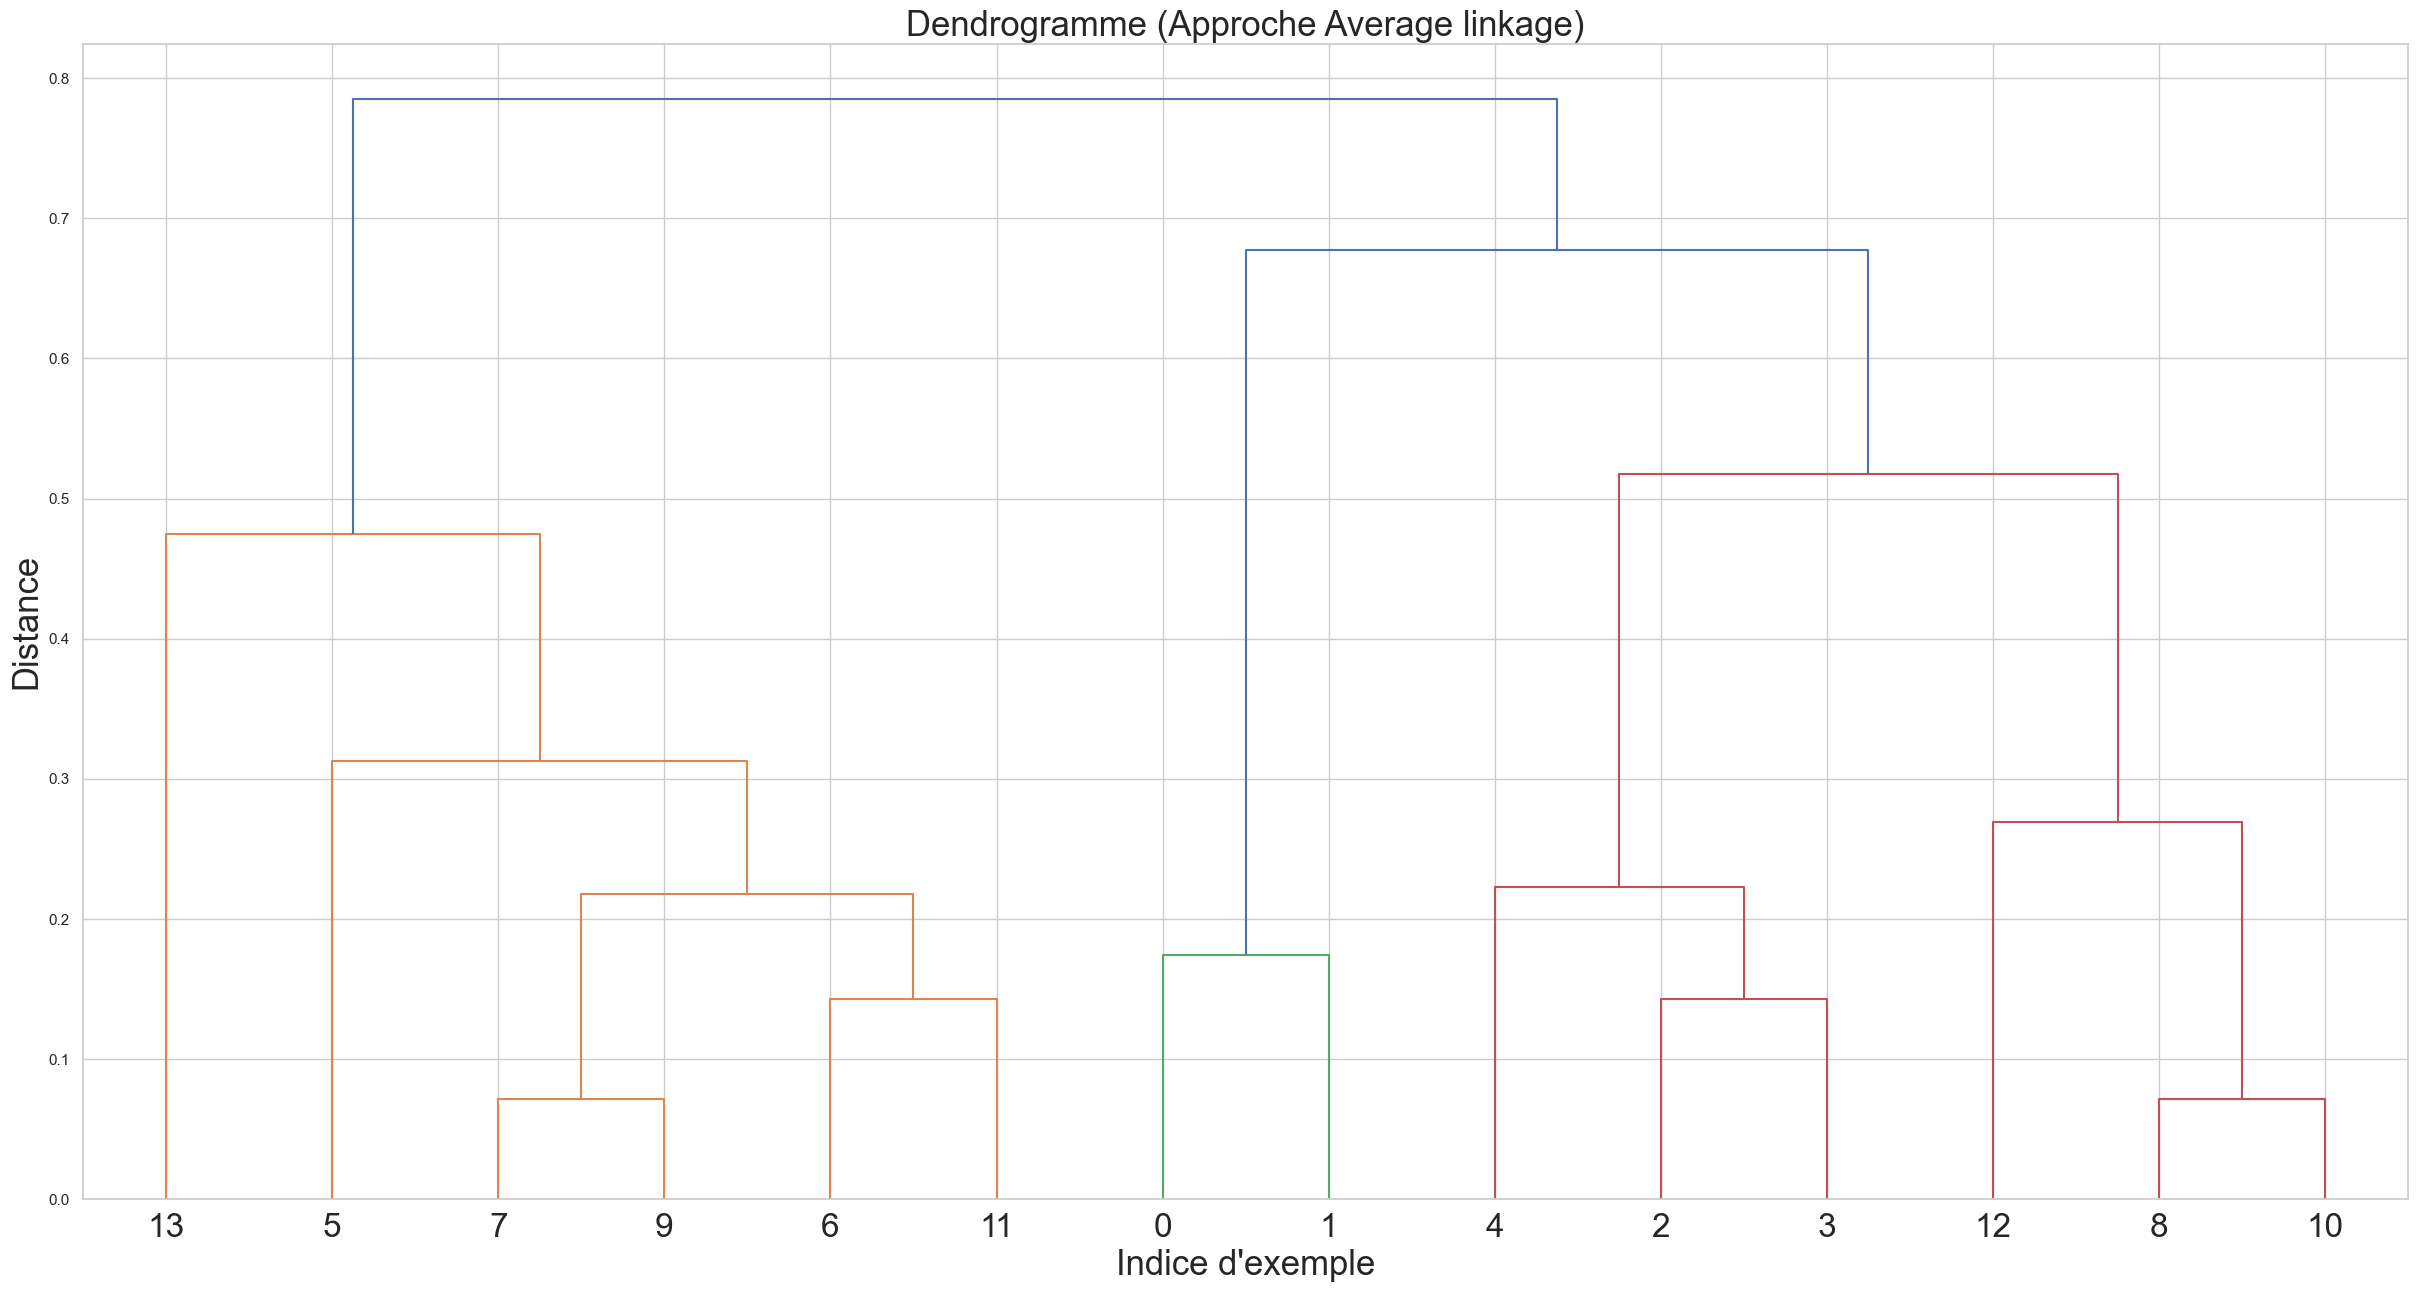

[[8, 10, 0.0714285714285714, 2],
 [7, 9, 0.07142857142857151, 2],
 [2, 3, 0.14285714285714285, 2],
 [6, 11, 0.1428571428571429, 2],
 [0, 1, 0.17437936593905287, 2],
 [15, 17, 0.2176313858168652, 4],
 [4, 16, 0.22289036095775183, 3],
 [12, 14, 0.2694495361626317, 3],
 [5, 19, 0.31302705657407515, 5],
 [13, 22, 0.4745491993187841, 6],
 [20, 21, 0.5175575371779451, 6],
 [18, 24, 0.6770324690297006, 8],
 [23, 25, 0.784963189028133, 14]]

In [75]:
CHA(data_2D_norm,linkage='average',dendrogramme=True)

### Une base pour voir les différences

Etudier les différences de résultats obtenus avec chacune des approches de linkage sur la base suivante.

In [ ]:
data_2D_diff = normalisation(pd.read_csv("data/base-2D-diff.csv"))

In [83]:
data_2D_diff

,X1,X2
0,0.000000,0.000000
1,0.000000,0.166667
2,0.133333,0.000000
3,0.133333,0.166667
4,0.133333,0.333333
5,0.266667,0.166667
6,0.266667,0.333333
7,0.266667,0.500000
8,0.400000,0.166667
9,0.400000,0.333333


In [ ]:
# X1_values = 
# X2_values = 



Il y a 23 exemples dans la base.


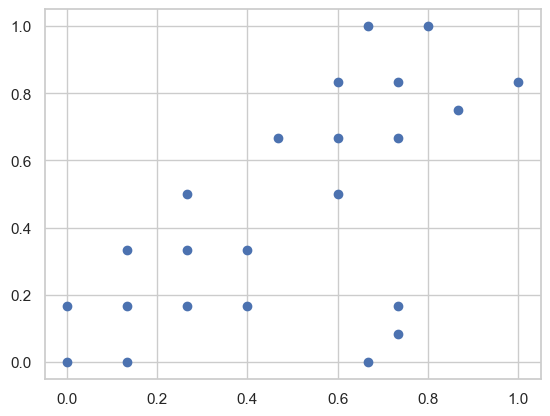

In [78]:
print("Il y a", len(data_2D_diff), "exemples dans la base.")

plt.scatter(X1_values,X2_values)


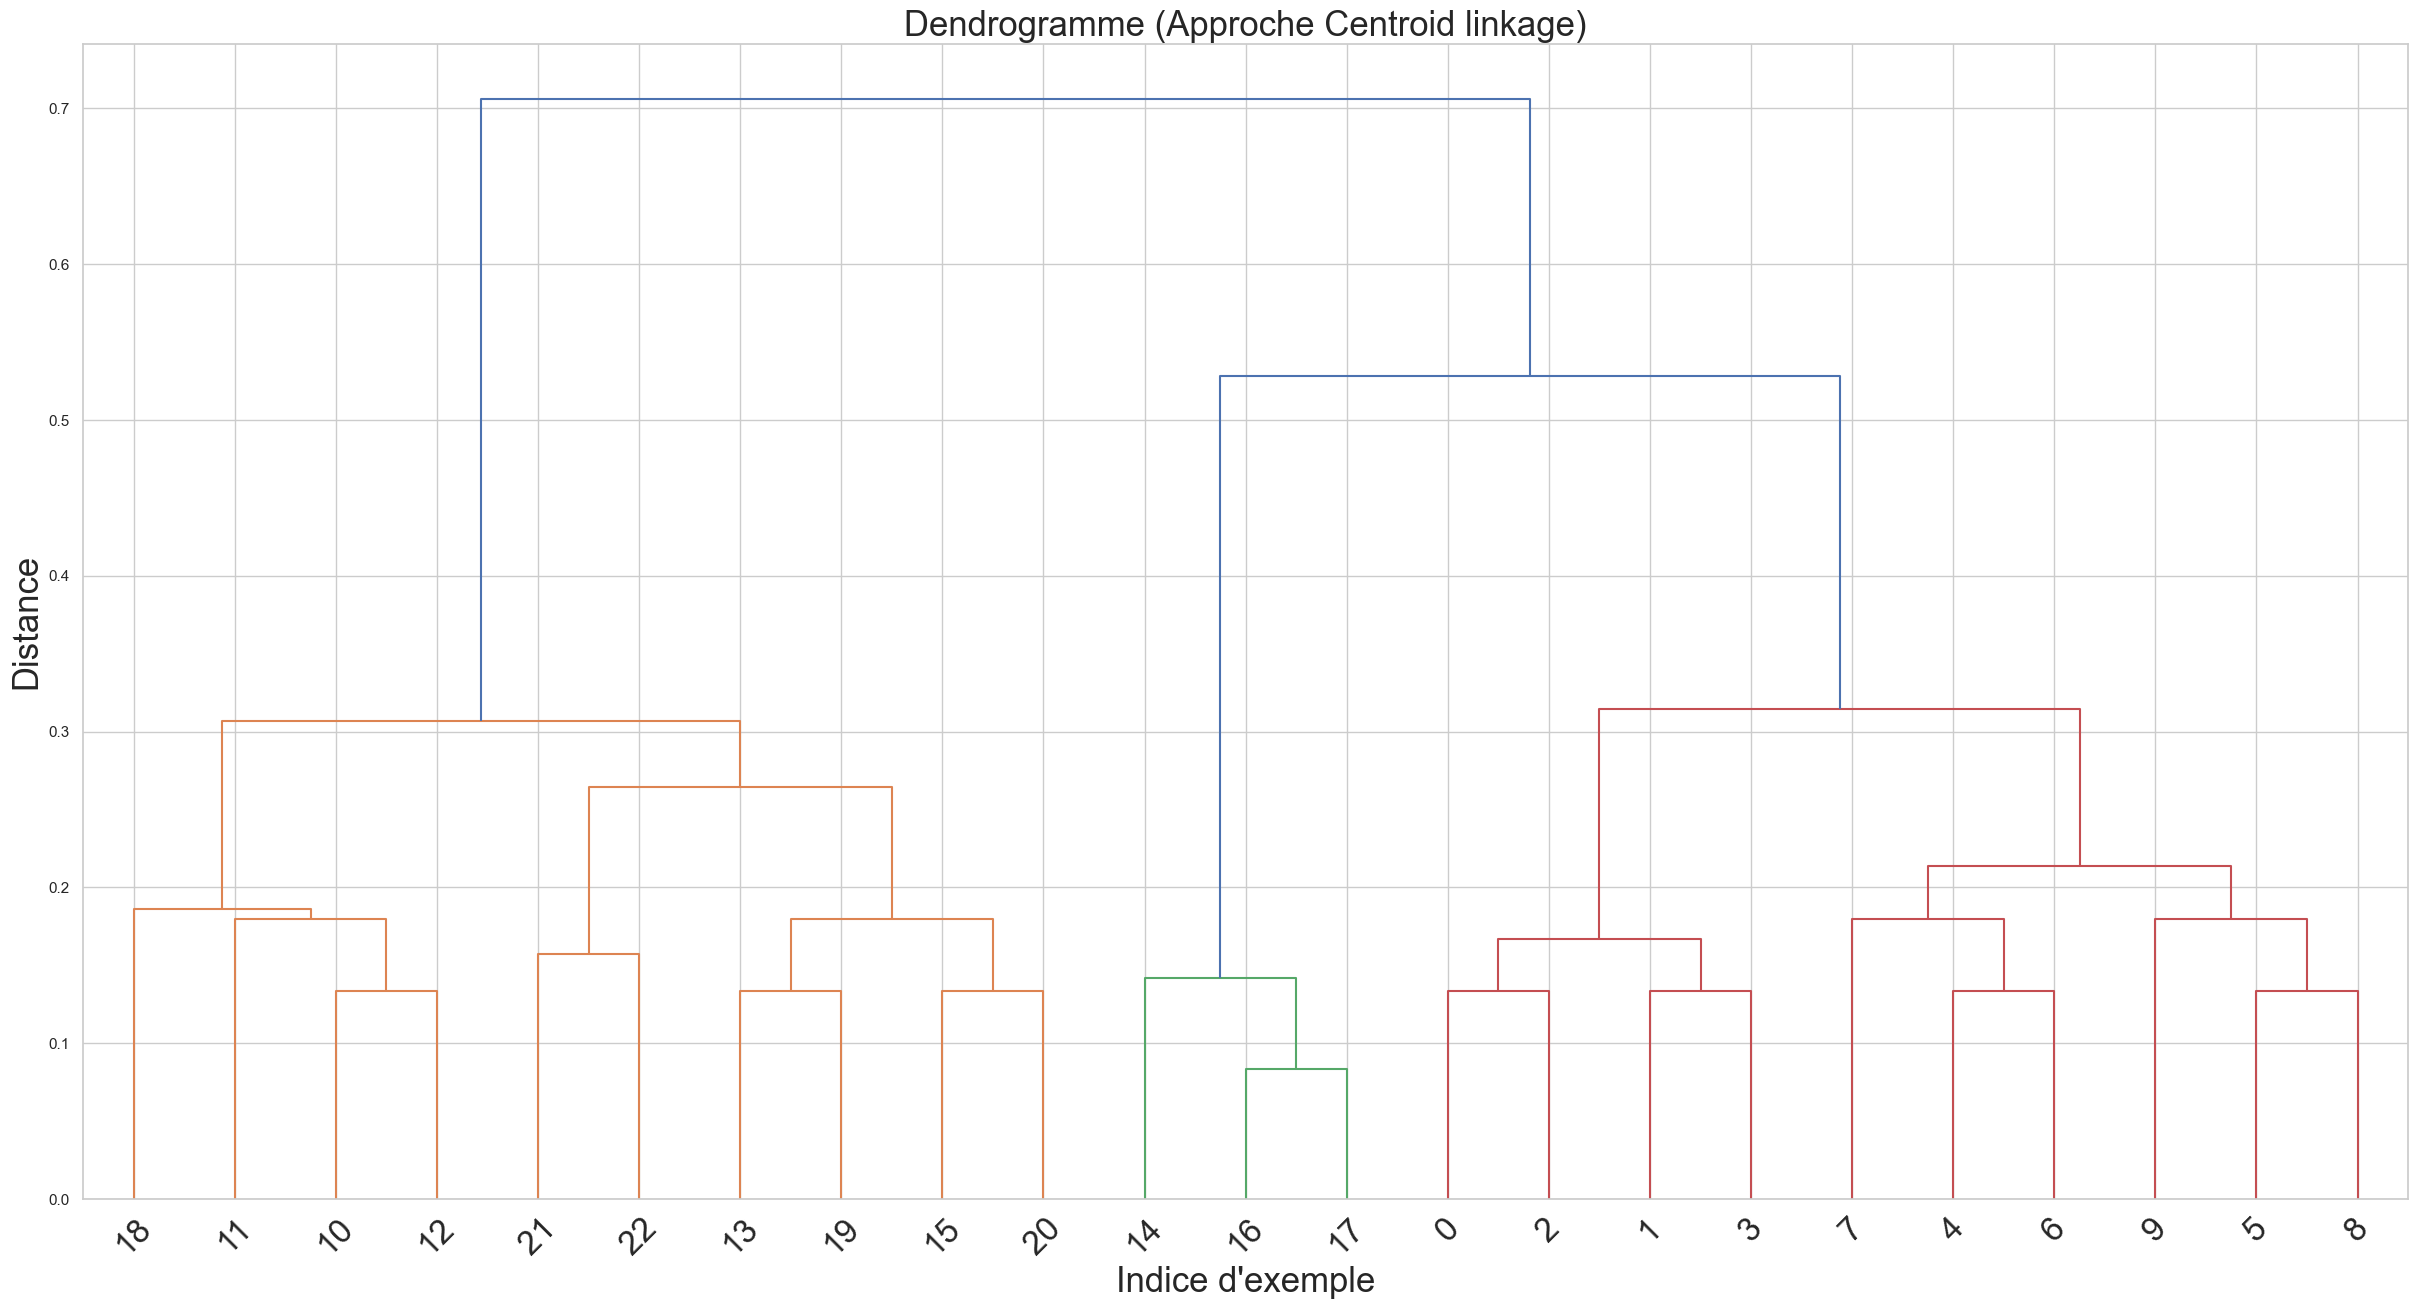

In [84]:
res_centroid = CHA(data_2D_diff,linkage='centroid',dendrogramme=True)

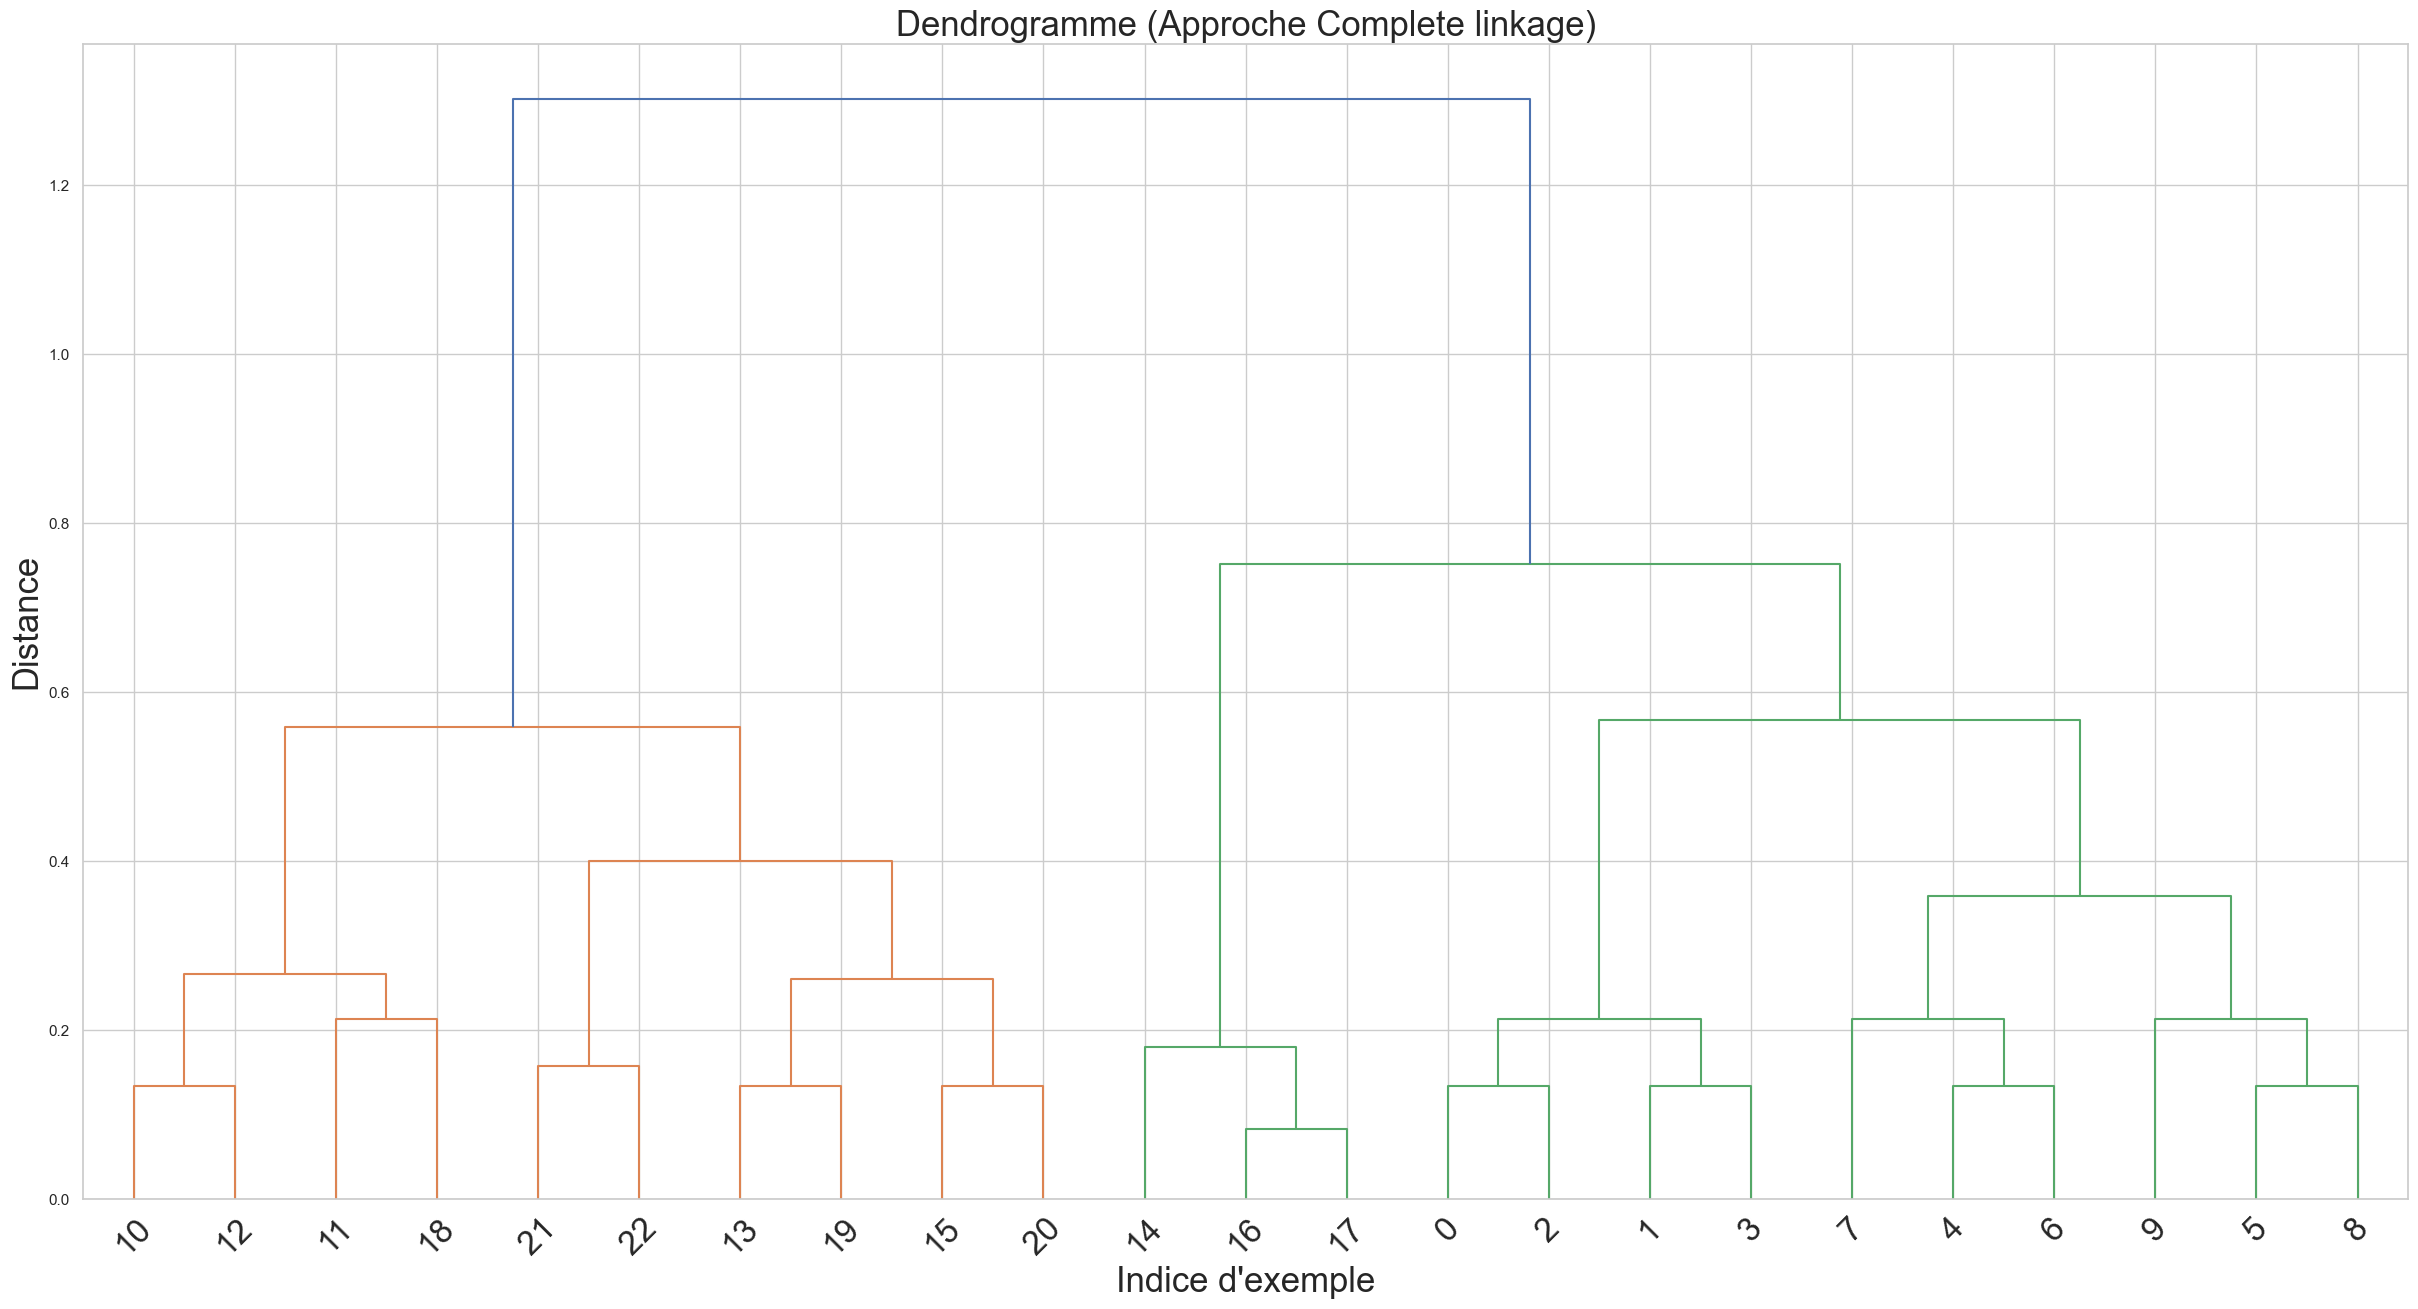

In [85]:
res_complete = CHA(data_2D_diff,linkage='complete',dendrogramme=True)

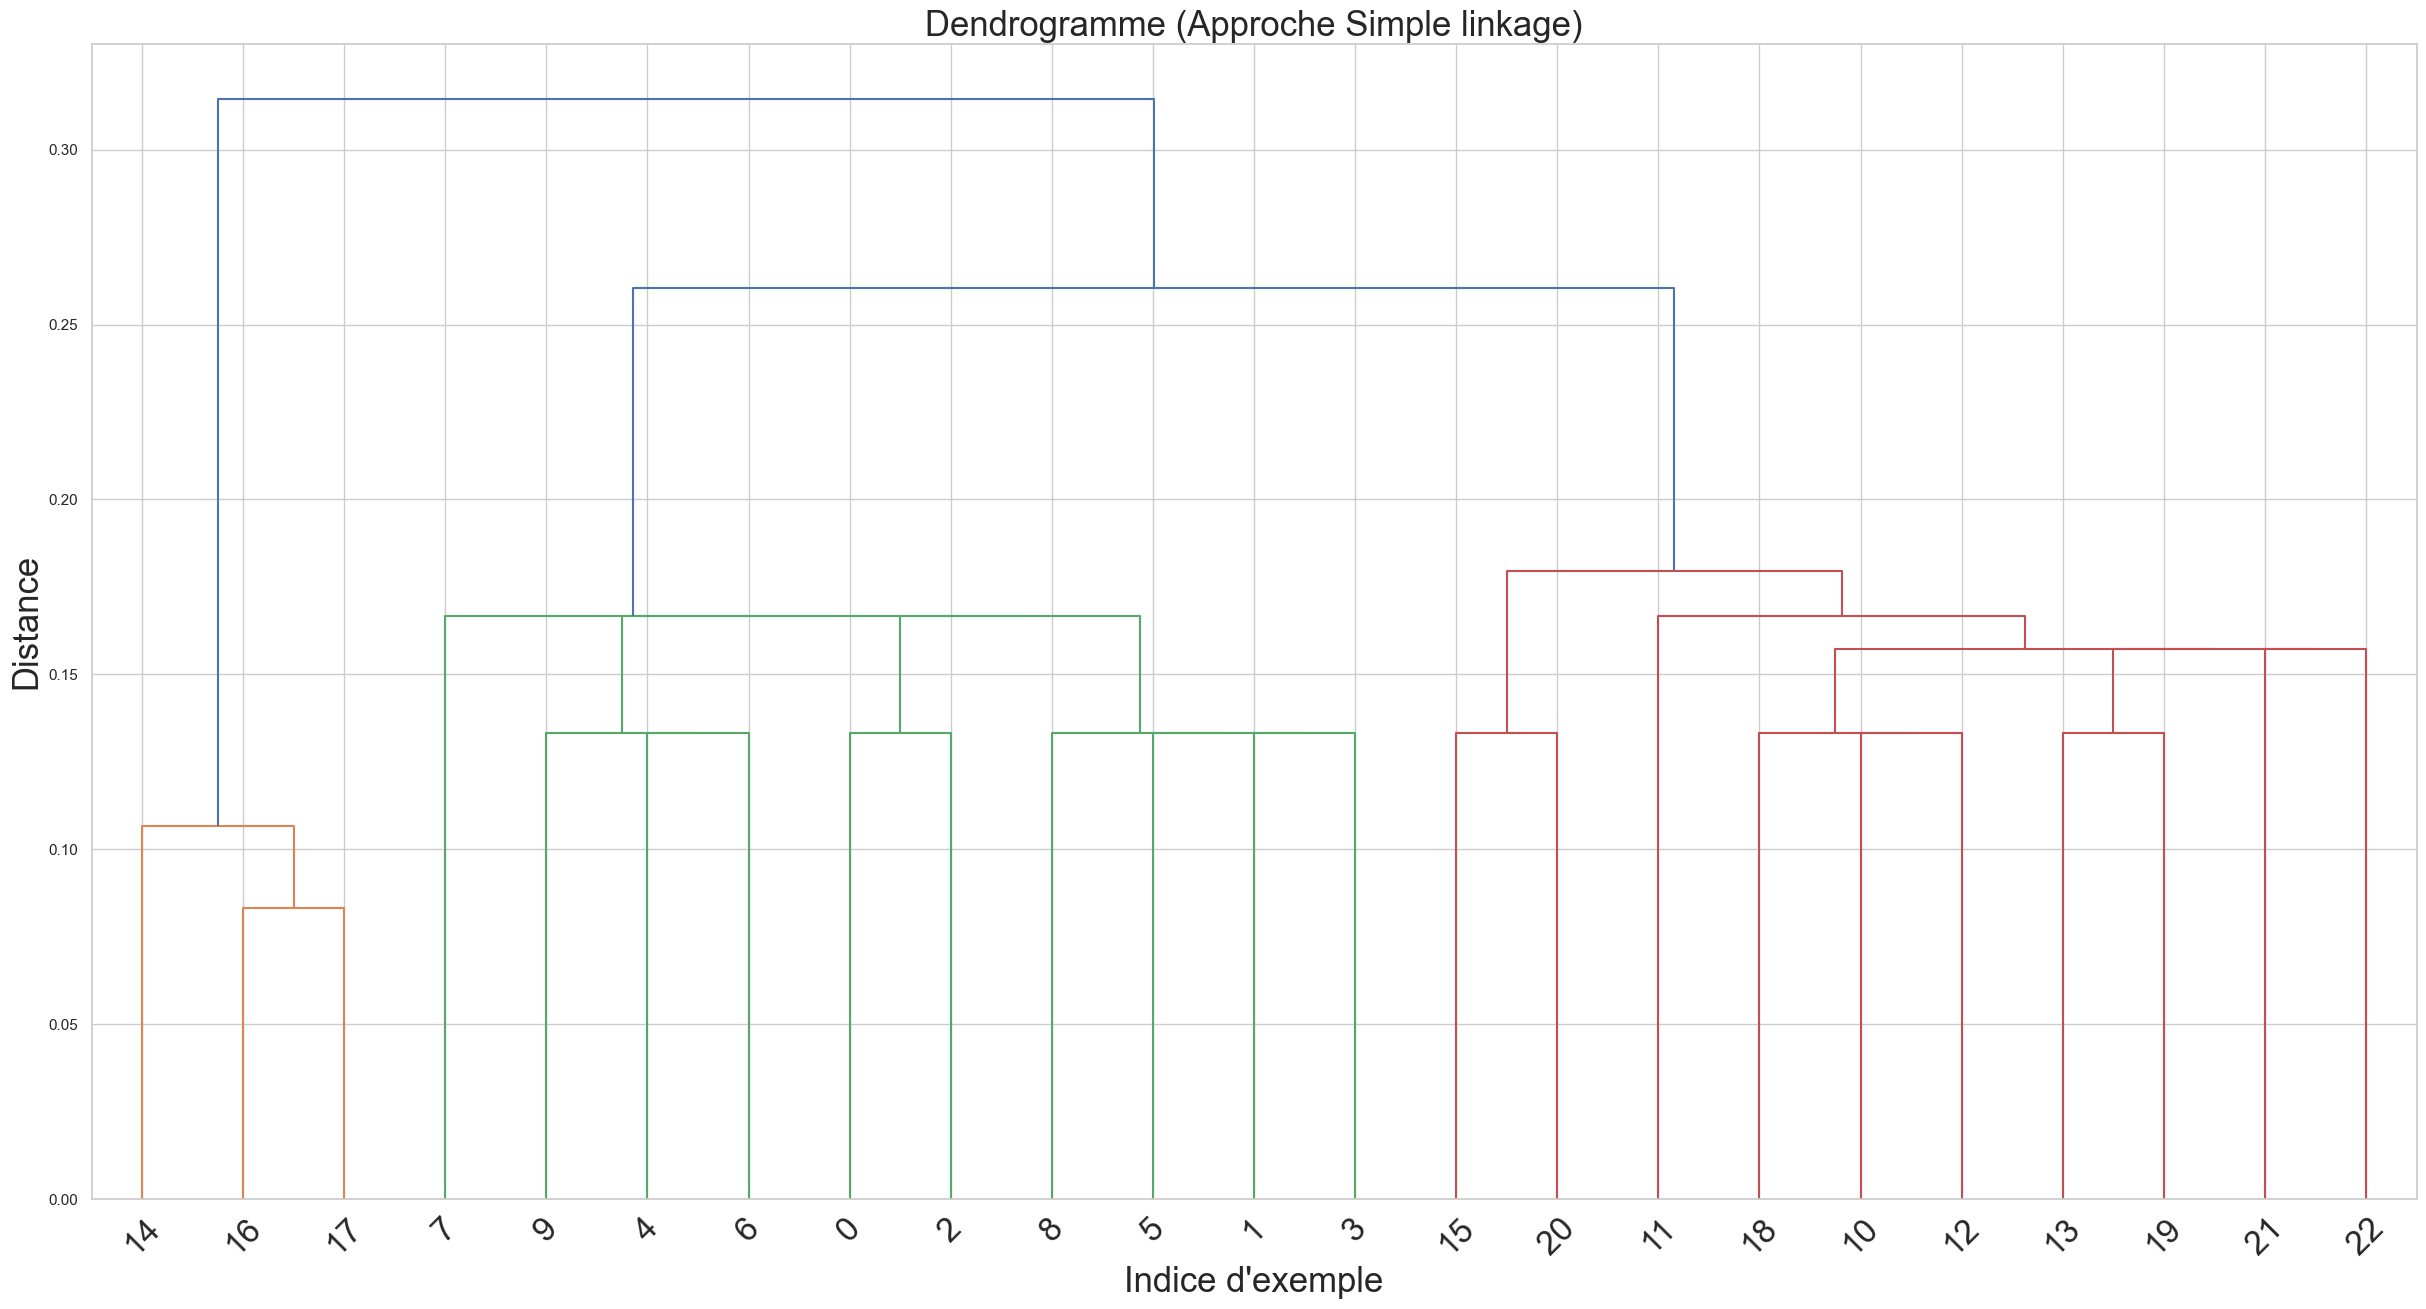

In [86]:
res_simple = CHA(data_2D_diff,linkage='simple',dendrogramme=True)

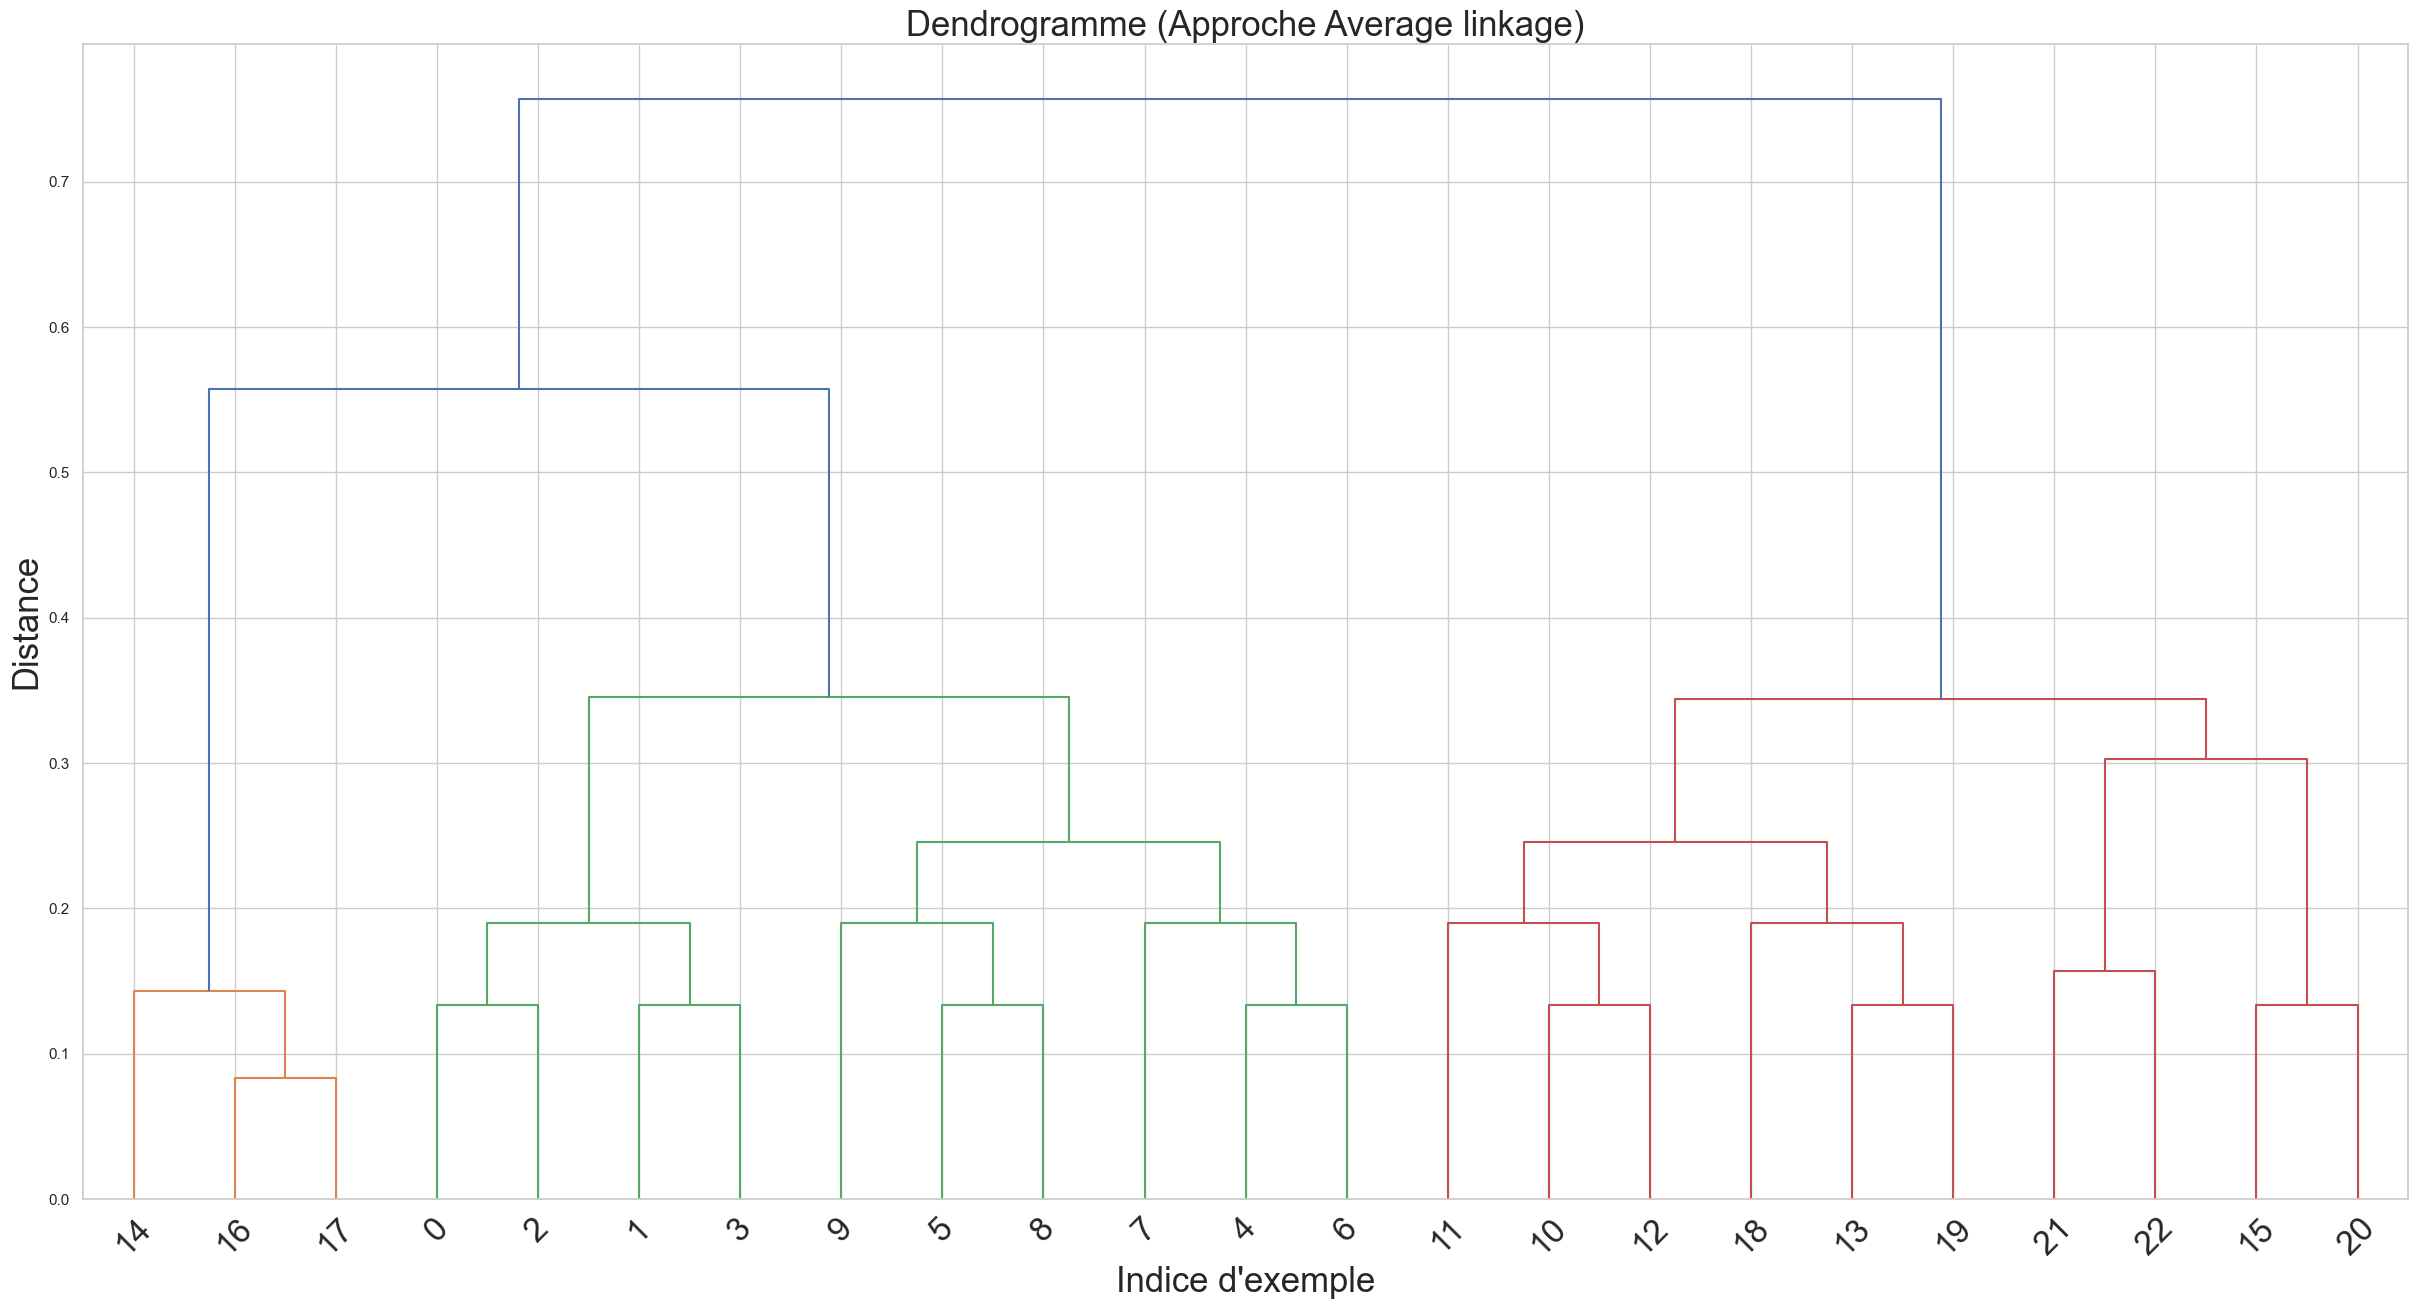

In [87]:
res_average = CHA(data_2D_diff,linkage='average',dendrogramme=True)

#### Ajout des fonctions dans la librairie `iads`

<font size="+1" color="RED"><b>[Q]</b></font> Ajouter les fonctions de clustering dans votre librairie `iads`. Pour cela, créer un nouveau fichier de nom `Clustering.py` dans votre répertoire `iads`. 
Utiliser les premières lignes du fichier `Classifiers.py` pour débuter votre fichier `Clustering.py`, puis rajouter dans ce fichier les fonctions de clustering hiérarchique (tous linkages) de ce notebook, ainsi que les fonctions qu'elles utilisent.

## Phase 2 : application à des données réelles

### Données: traitement des déchets de la ville de Paris

Pour tester votre implémentation, vous allez utiliser les données publiques de traitement des déchets de la ville de Paris qui sont fournies dans le fichier `base-Paris.csv`.

**Attention**: il faut préparer cette base afin de pouvoir appliquer l'algorithme de clustering: en particulier, certaines colonnes (Granularité, Total...) ne sont pas à utilisables dans le calcul des distances, il faut donc les éliminer. Il faut aussi prévoir de conserver le nom de l'arrondissement afin de pouvoir à la fin analyser le résultat du clustering.


<font size="+1" color="RED"><b>[Q]</b></font> Etudier cette base et les clusters qui peuvent être mis en évidence.


In [ ]:
data_Paris = # A COMPLETER

In [89]:
data_Paris

,Granularité,janv-11,févr-11,mars-11,avr-11,mai-11,juin-11,juil-11,août-11,sept-11,oct-11,nov-11,déc-11,Total-2011
0,75001,75.3,60.4,71.2,59.5,73.9,72.0,57.9,56.4,75.5,75.7,65.8,79.1,822.7
1,75002,153.0,125.8,136.6,126.6,133.2,127.6,126.7,114.3,144.3,145.1,129.5,129.8,1592.5
2,75003,183.9,173.1,204.2,183.0,203.2,181.9,191.2,153.6,208.6,186.5,192.9,189.9,2252.0
3,75004,116.3,115.7,133.4,115.0,123.2,120.5,114.5,97.6,130.5,123.0,124.3,133.7,1447.7
4,75005,247.0,211.0,251.0,218.0,185.0,224.0,213.3,162.9,203.4,232.1,227.6,251.6,2626.9
5,75006,222.0,189.0,218.0,192.0,180.0,199.0,171.8,134.8,183.1,195.5,213.8,204.1,2303.1
6,75007,288.1,249.1,303.7,255.8,287.8,288.4,249.6,185.6,281.3,284.3,296.4,301.1,3271.2
7,75008,252.6,246.7,252.9,232.5,199.4,236.4,175.4,189.4,266.6,230.3,257.7,224.4,2764.3
8,75009,208.3,197.1,220.4,197.9,151.7,206.9,199.9,163.3,223.8,203.6,213.8,235.7,2422.4
9,75010,273.0,248.6,292.2,255.2,284.3,267.3,246.6,210.3,280.6,275.6,284.6,283.2,3201.5


<font size="+1" color="RED"><b>[Q]</b></font> Préparer un rapport d'analyse (c'est-à-dire, compléter votre notebook en rajoutant à la suite tout un ensemble d'expérimentations et de résultats obtenus sur la base) réalisé sur cette base qui mette en évidence les clusters existants à différents niveaux de distance, et en utilisant différentes distances.
